In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image
import numpy as np
import glob
from pathlib import Path
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import ConfusionMatrixDisplay

# Exploratory Data Analysis(Provided Data)

## Analyzing Data Distribution

In [2]:
image_list = []
base_dir = 'trafficsigns_dataset'

# Loop through each directory and append only images to image_list
for filepath in glob.glob(os.path.join(base_dir, '*', '*', '*.png')):
    filename = os.path.basename(filepath)
    sign_type = os.path.basename(os.path.dirname(filepath))
    sign_shape = os.path.basename(os.path.dirname(os.path.dirname(filepath)))
    image_path = os.path.join(sign_shape, sign_type)

    img = Image.open(filepath)  

    image_list.append(('./' + filepath, image_path, filename, sign_shape, sign_type, f"{img.width}x{img.height}"))
    img.close()
    
# create dataframe
data = pd.DataFrame(data=image_list, columns=['filepath', 'image_path', 'filename' ,'sign_shape' ,'sign_type', 'dimension'])

In [3]:
data.head(10)
data.shape

(3699, 6)

In [4]:
# Output the result.
print("Following are the count of the number of images in each shape: \n")
data['image_path'].value_counts()

Following are the count of the number of images in each shape: 



image_path
triangle/warning          695
round/noentry             375
round/speed               316
round/bicycle             285
diamond/rightofway        282
square/parking            276
round/noparking           242
triangle/giveway          231
square/continue           199
round/trafficdirective    195
round/limitedtraffic      125
round/traveldirection     124
square/laneend            118
round/roundabout           98
square/crossing            95
hex/stop                   43
Name: count, dtype: int64

### Now I will analyze the number of images in each sub-directory i.e. image type in each shape using histogram

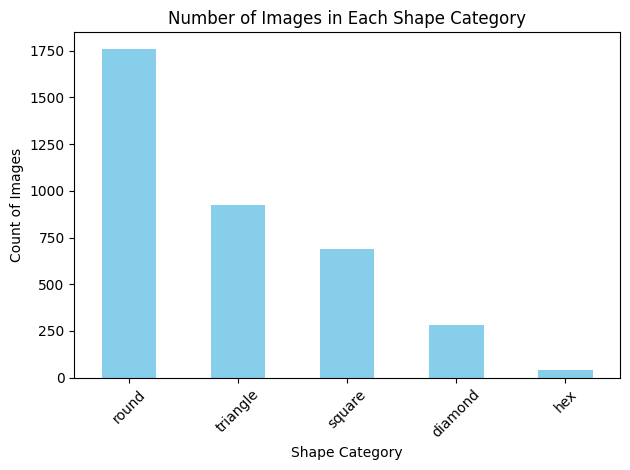

In [5]:
# plot histogram of sign shapes
data['sign_shape'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Number of Images in Each Shape Category')
plt.xlabel('Shape Category')
plt.ylabel('Count of Images')
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust the layout to ensure everything fits without overlap
plt.show()


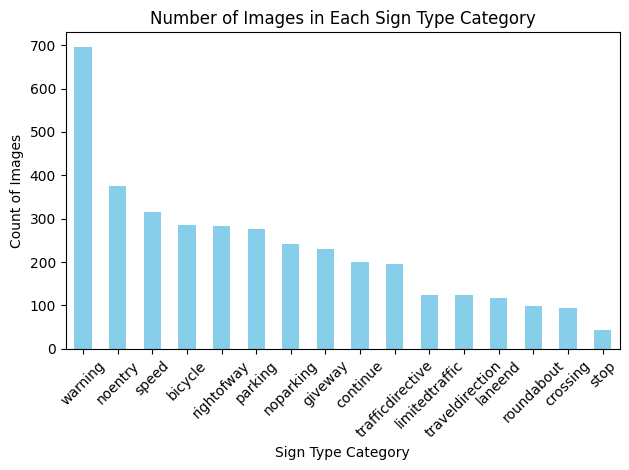

In [6]:
# plot histogram of sign shapes
data['sign_type'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Number of Images in Each Sign Type Category')
plt.xlabel('Sign Type Category')
plt.ylabel('Count of Images')
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust the layout to ensure everything fits without overlap
plt.show()


## Analyzing Size Distribution

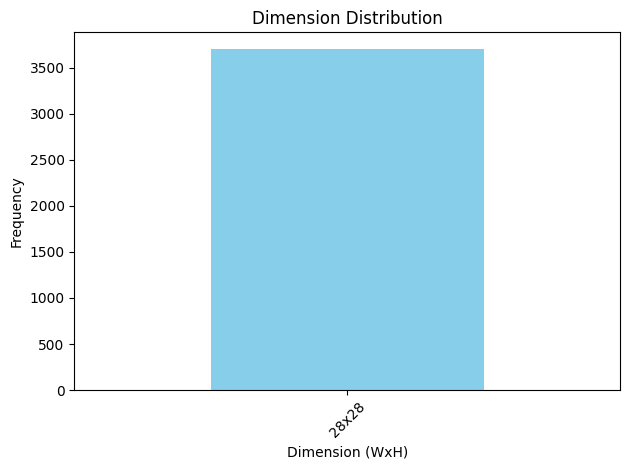

In [7]:
# Plotting
data['dimension'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Dimension Distribution')
plt.xlabel('Dimension (WxH)')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Color Analysis

The following code computes and visualizes the average distribution of pixel intensities for the Red, Green, and Blue channels across all images in a specified dataset. It does this by:

1. Initializing storage to accumulate color data and track the number of images.
2. Iterating through the dataset's directory structure, processing each image to extract its color histograms.
3. Averaging these histograms by channel to get a sense of the typical color profile across the dataset.
4. Plotting the averaged histograms for visual analysis, presenting the commonality of pixel intensities in each color channel across the dataset.
The resulting visualizations provide insights into the dominant colors and brightness levels within the traffic sign images, which is valuable for understanding the data's characteristics and preparing for machine learning tasks.

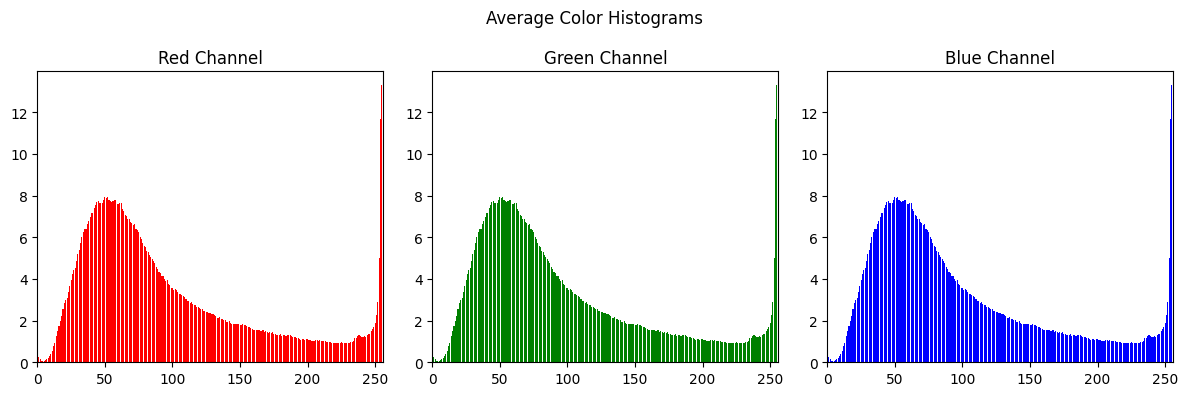

In [8]:
color_sums = [np.zeros(256), np.zeros(256), np.zeros(256)]  # For RGB channels
num_images = 0

# Loop through each subdirectory and compute color histograms
for image in image_list:
    file_path = image[0]
    with Image.open(file_path) as img:
        img = img.convert('RGB')  # Ensure image is in RGB
        for i in range(3):  # RGB channels
            hist, _ = np.histogram(img.getdata(band=i), bins=256, range=(0, 256))
            color_sums[i] += hist
        num_images += 1

# Calculate the average histograms
avg_histograms = [sums / num_images for sums in color_sums]

# Plot the average histograms
plt.figure(figsize=(12, 4))
colors = ['Red', 'Green', 'Blue']
for i, color in enumerate(colors):
    plt.subplot(1, 3, i + 1)
    plt.bar(range(256), avg_histograms[i], color=color.lower())
    plt.title(f'{color} Channel')
    plt.xlim([0, 256])
plt.suptitle('Average Color Histograms')
plt.tight_layout()
plt.show()


The following function checks whether a given image is in grayscale or not. 

In [9]:
def is_grey_scale(img_path):
    img = Image.open(img_path).convert('RGB')
    w, h = img.size
    for i in range(w):
        for j in range(h):
            r, g, b = img.getpixel((i, j))
            if r != g or r != b:
                return False
    return True

The following code is designed to automate the process of checking each image in the dataset to determine whether it is in grayscale or not. Here's what each part of the script does:

1. Set Base Directory: The base_dir variable is set to the directory containing the dataset, labeled 'trafficsigns_dataset'.
2. Iterate Through Directory Structure: The script loops through each subdirectory, which represents different shapes and types of traffic signs.
3. Open Each Image: Each image file is opened, and a check is performed to see if the image is in grayscale.
4. Check for Color: The is_grey_scale function (not shown in this snippet) is called for each image. This function checks if each pixel has the same value for the red, green, and blue color channels. If a pixel is found with differing values, the image is not in grayscale.
5. Output Result: If a colored image is found (meaning the image is not in grayscale), the script prints the path of the image and a message stating that not all images are in grayscale.
6. Early Exit: Once a single colored image is found, the script breaks out of the loop, ending the execution. This is done because only one instance of a colored image is needed to determine that the dataset is not entirely in grayscale.

In [10]:
for image in image_list:
    file_path = image[0]
    if not is_grey_scale(file_path):
        print(f"Colored image found: {file_path}")
        print("Not All Images Are Gray")
        break  # If one colored image is found, we can stop checking


## Data Splitting

Since we are are going to test our model with real world data which would be completely unseen, we are only splitting it into train and validation in 80 - 20 percent respectively.

In [11]:
data

,filepath,image_path,filename,sign_shape,sign_type,dimension
0,./trafficsigns_dataset/diamond/rightofway/0003...,diamond/rightofway,00039_00001.png,diamond,rightofway,28x28
1,./trafficsigns_dataset/diamond/rightofway/0180...,diamond/rightofway,01803_00002.png,diamond,rightofway,28x28
2,./trafficsigns_dataset/diamond/rightofway/0170...,diamond/rightofway,01702_00000.png,diamond,rightofway,28x28
3,./trafficsigns_dataset/diamond/rightofway/0011...,diamond/rightofway,00111_00001.png,diamond,rightofway,28x28
4,./trafficsigns_dataset/diamond/rightofway/0123...,diamond/rightofway,01231_00003.png,diamond,rightofway,28x28
...,...,...,...,...,...,...
3694,./trafficsigns_dataset/round/trafficdirective/...,round/trafficdirective,00630_00001.png,round,trafficdirective,28x28
3695,./trafficsigns_dataset/round/trafficdirective/...,round/trafficdirective,01916_00002.png,round,trafficdirective,28x28
3696,./trafficsigns_dataset/round/trafficdirective/...,round/trafficdirective,00701_00002.png,round,trafficdirective,28x28
3697,./trafficsigns_dataset/round/trafficdirective/...,round/trafficdirective,00465_00002.png,round,trafficdirective,28x28


In [12]:
train_data, val_data = train_test_split(data, test_size=0.2, random_state=2024)

print("Train data : {}, Val Data: {}".format(train_data.shape[0], val_data.shape[0]))

Train data : 2959, Val Data: 740


### Data Leakage Check

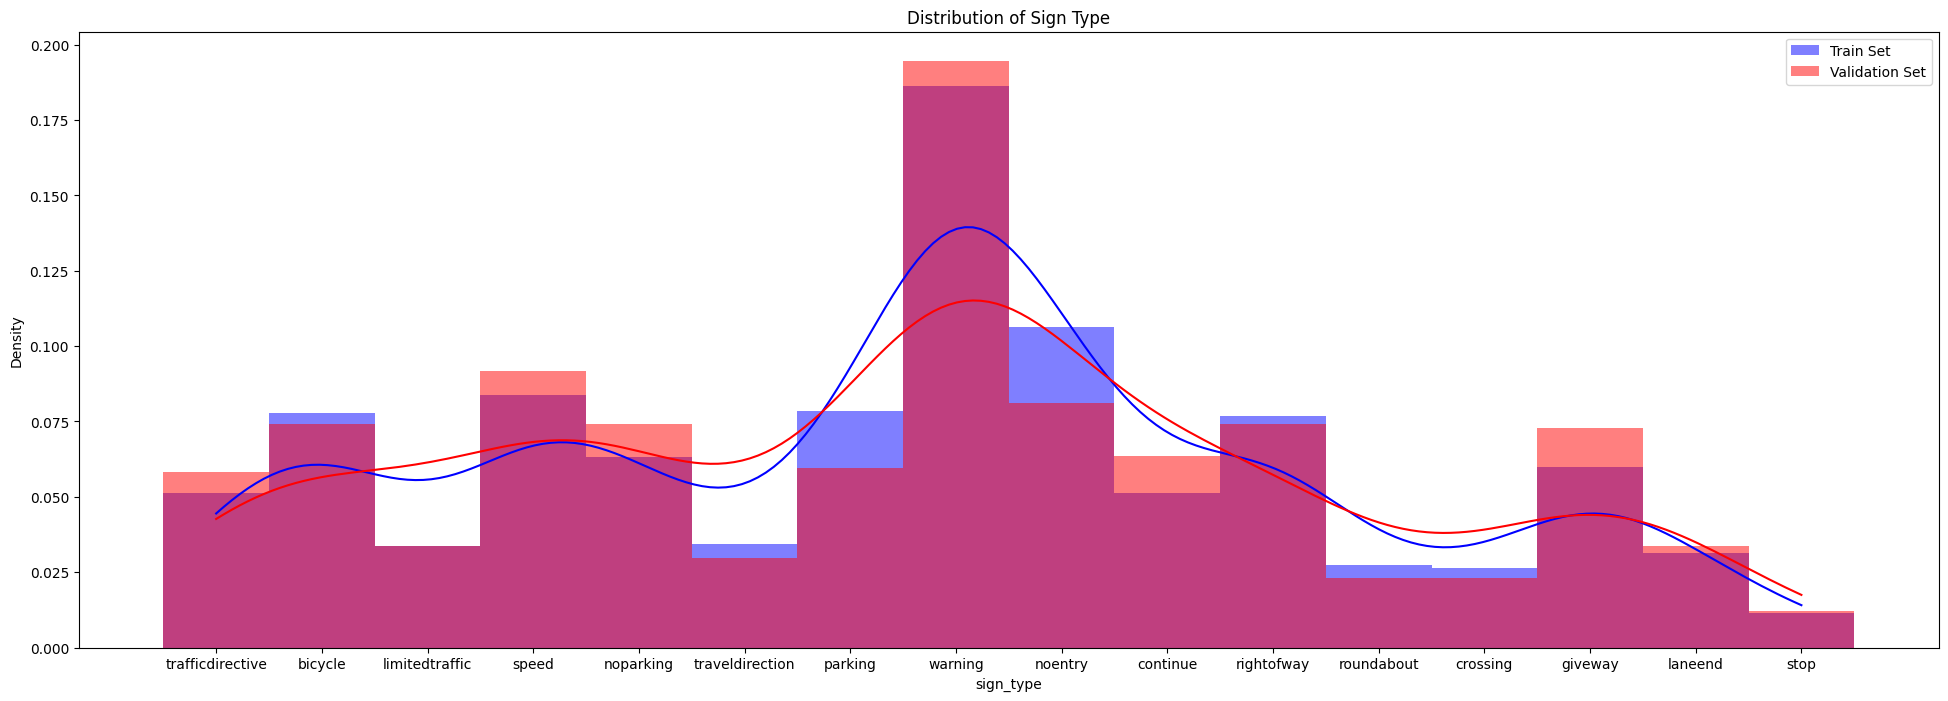

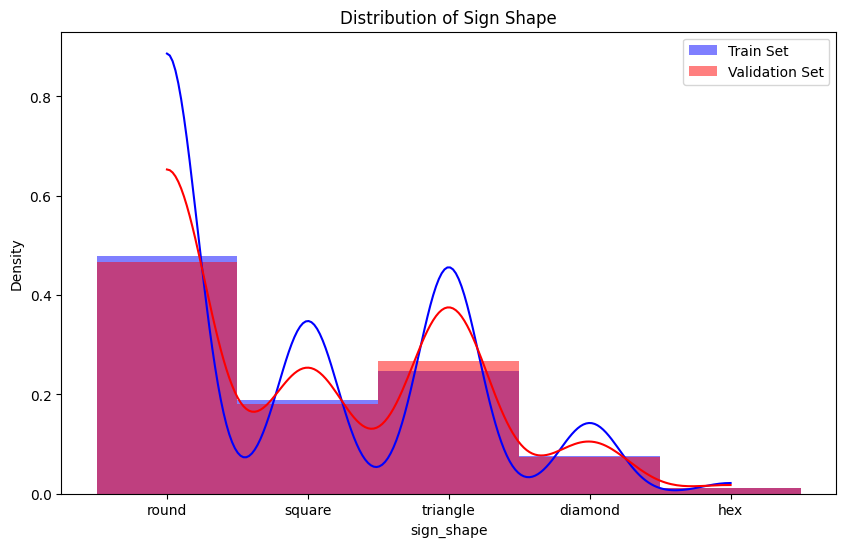

In [13]:
# Figure for 'sign_type'
plt.figure(figsize=(24, 8))  # Adjust the figure size as needed for clarity
sns.histplot(train_data['sign_type'], color="blue", label='Train Set', kde=True, stat="density", linewidth=0, alpha=0.5)
sns.histplot(val_data['sign_type'], color="red", label='Validation Set', kde=True, stat="density", linewidth=0, alpha=0.5)
plt.title('Distribution of Sign Type')
plt.legend()
plt.show()

# Figure for 'sign_shape'
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed for clarity
sns.histplot(train_data['sign_shape'], color="blue", label='Train Set', kde=True, stat="density", linewidth=0, alpha=0.5)
sns.histplot(val_data['sign_shape'], color="red", label='Validation Set', kde=True, stat="density", linewidth=0, alpha=0.5)
plt.title('Distribution of Sign Shape')
plt.legend()
plt.show()


#### Distribution of Sign Type
- **Overlap and Similarity**: Both training and validation sets show similar distributions for `sign_type`, suggesting that the validation set mirrors the training data well.
- **Density Peaks and Values**: There are consistent peaks across both datasets, indicating that each `sign_type` is represented similarly in both, which is crucial for model training.

#### Distribution of Sign Shape
- **Shape Distribution**: The histograms for `sign_shape` also demonstrate good overlap between the training and validation sets, showing that both sets contain similar proportions of each shape type.
- **Density and Peaks**: The presence of consistent peaks for common shapes like "round" and "square" across both datasets further confirms the good representation in both sets.

### Conclusion on Data Leakage
- **No Apparent Data Leakage**: The histograms do not display typical signs of data leakage, where features in the training set would excessively influence the model in a way not replicable in the validation set.
- **Good Dataset Split**: The data split appears to be effective, suggesting that the validation set can provide a realistic indication of the model's performance on new, unseen data.

These observations indicate that the dataset is well-prepared, with a balanced split that should support effective model training and validation.


# Exploratory Data Analysis for Test Data(Unseen Data)

In [14]:
# go through trafficsigns_testset folders. Resizes, convert to grayscale, then re-save as png in new directory.
base_dir = 'trafficsigns_testset'
for filepath in glob.glob(os.path.join(base_dir, '*', '*', '*.jpg')):
    filename = os.path.basename(filepath)
    filename_excl_ext = Path(filename).stem
    sign_type = os.path.basename(os.path.dirname(filepath))
    sign_shape = os.path.basename(os.path.dirname(os.path.dirname(filepath)))
    image_path = os.path.join(sign_shape, sign_type)

    new_dir = os.path.join('trafficsigns_testset' + '_final', image_path)
    os.makedirs(new_dir, exist_ok=True)

    # convert to grayscale and resize
    img = Image.open(filepath).convert('L').resize((28,28))
     # save as png
    img.save(f"{new_dir}/" + filename_excl_ext + '.png')

    img.close()

In [15]:
eval_list = []
base_dir = 'trafficsigns_testset_final'

# Loop through each directory and append only images to image_list
for filepath in glob.glob(os.path.join(base_dir, '*', '*', '*.png')):
    filename = os.path.basename(filepath)
    sign_type = os.path.basename(os.path.dirname(filepath))
    sign_shape = os.path.basename(os.path.dirname(os.path.dirname(filepath)))
    image_path = os.path.join(sign_shape, sign_type)

    img = Image.open(filepath)

    eval_list.append(('./' + filepath, image_path, filename, sign_shape, sign_type, f"{img.width}x{img.height}"))
    img.close()

# create dataframe
eval_data = pd.DataFrame(data=eval_list, columns=['filepath', 'image_path', 'filename' ,'sign_shape' ,'sign_type', 'dimension'])

In [16]:
eval_data.head(10)
eval_data.shape

(489, 6)

In [17]:
# Output the result.
print("Following are the count of the number of images in each shape: \n")
eval_data['image_path'].value_counts()

Following are the count of the number of images in each shape: 



image_path
round/speed               43
round/noentry             40
round/trafficdirective    36
square/parking            33
triangle/warning          33
square/laneend            32
triangle/giveway          32
diamond/rightofway        31
hex/stop                  31
square/continue           30
square/crossing           29
round/traveldirection     29
round/bicycle             27
round/noparking           24
round/roundabout          23
round/limitedtraffic      16
Name: count, dtype: int64

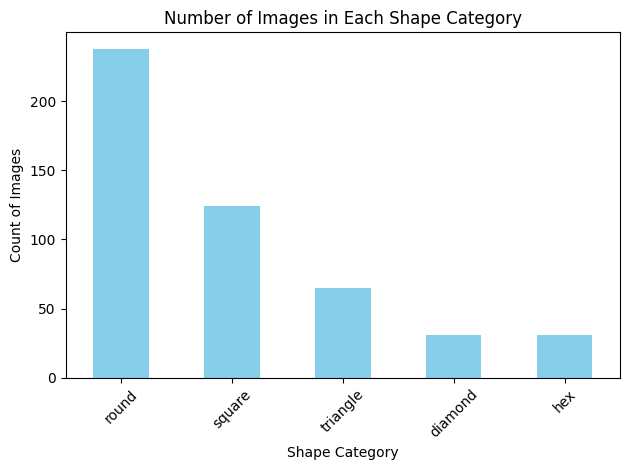

In [18]:
# plot histogram of sign shapes
eval_data['sign_shape'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Number of Images in Each Shape Category')
plt.xlabel('Shape Category')
plt.ylabel('Count of Images')
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust the layout to ensure everything fits without overlap
plt.show()

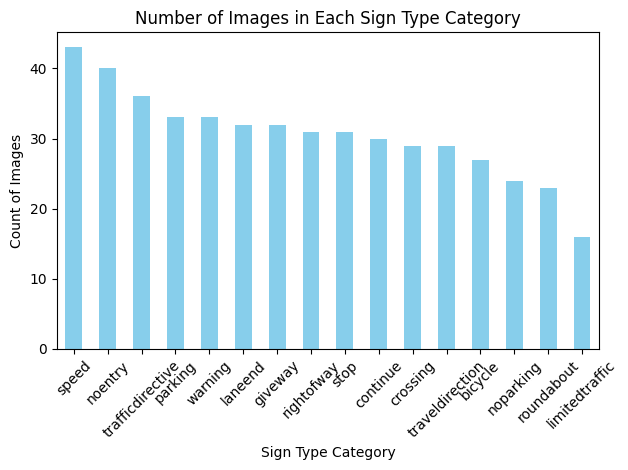

In [19]:
# plot histogram of sign shapes
eval_data['sign_type'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Number of Images in Each Sign Type Category')
plt.xlabel('Sign Type Category')
plt.ylabel('Count of Images')
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust the layout to ensure everything fits without overlap
plt.show()


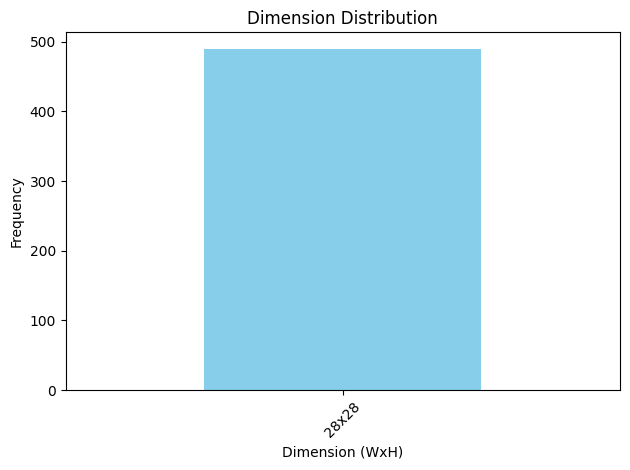

In [20]:
# Plotting
eval_data['dimension'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Dimension Distribution')
plt.xlabel('Dimension (WxH)')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

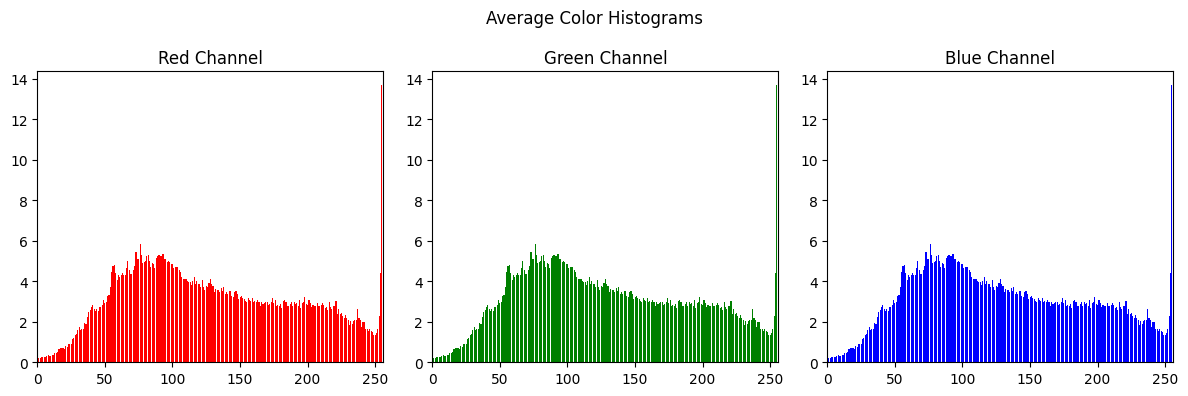

In [21]:
color_sums = [np.zeros(256), np.zeros(256), np.zeros(256)]  # For RGB channels
num_images = 0

# Loop through each subdirectory and compute color histograms
for image in eval_list:
    file_path = image[0]
    with Image.open(file_path) as img:
        img = img.convert('RGB')  # Ensure image is in RGB
        for i in range(3):  # RGB channels
            hist, _ = np.histogram(img.getdata(band=i), bins=256, range=(0, 256))
            color_sums[i] += hist
        num_images += 1

# Calculate the average histograms
avg_histograms = [sums / num_images for sums in color_sums]

# Plot the average histograms
plt.figure(figsize=(12, 4))
colors = ['Red', 'Green', 'Blue']
for i, color in enumerate(colors):
    plt.subplot(1, 3, i + 1)
    plt.bar(range(256), avg_histograms[i], color=color.lower())
    plt.title(f'{color} Channel')
    plt.xlim([0, 256])
plt.suptitle('Average Color Histograms')
plt.tight_layout()
plt.show()

In [22]:
for image in eval_list:
    file_path = image[0]
    if not is_grey_scale(file_path):
        print(f"Colored image found: {file_path}")
        print("Not All Images Are Gray")
        break  # If one colored image is found, we can stop checking

# Model Development

## Evaluation Metric

### Chosen Metrics: Accuracy and Weighted F1-Score

#### Accuracy
- **General Performance Indicator**: Accuracy measures the overall correctness of the model, which is the ratio of correctly predicted observations to the total observations. It provides a quick and intuitive measure of the model's general effectiveness.
- **Simple and Transparent**: As a straightforward metric, accuracy gives a clear, easy-to-understand indication of how often the model is correct across all predictions.

#### Weighted F1-Score
- **Addresses Class Imbalance**: Given the uneven distribution of classes in our dataset, the weighted F1-Score is particularly useful. It adjusts the F1-Score for each class by the number of true instances, giving more weight to classes with more samples.
- **Balanced Evaluation**: This metric provides a balance between precision and recall in a single number, weighted by the class distribution. It is crucial for our dataset where some sign types and shapes are less frequent but equally important for the model to identify correctly.
- **Emphasis on Minority Classes**: By using a weighted approach, we ensure that the model's performance on less common classes significantly influences the overall score. This is vital in scenarios where failing to detect a rare but important class could be more consequential than misclassifying a more common class.

### Conclusion
The combination of accuracy and weighted F1-Score provides a comprehensive evaluation framework. Accuracy offers an overview of overall model performance, while weighted F1-Score provides depth by taking into account class imbalance, ensuring that our model performs well across all classes, not just the majority class.

## Baseline Model

We Will use ANN(Artifical Neural Network) as our baseline model. <br><br>
It is because: <br>
1. By starting with an ANN, we can establish a straightforward performance metric to see if the complexity added by CNNs(which we will do in later part) is justified. This is particularly useful in scenarios where deployment constraints (like computational resources) are a concern.


2. Ultimately, using an ANN as a baseline allows to set a performance benchmark for the dataset. We will later enhance our model architecture to a CNN and compare the performance to see if the increased complexity offers significant improvements in accuracy.

<p style="color: red;"> Note: We Will be training 2 seperate models(For Baseline) for classifying shape size and type</p>

In [23]:
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

In [24]:
def show_image_prediction(model_name, output_class, class_items, dataframe):

    datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

    # use same val_data set but with batch size 1 and generate a random image generator 
    image_generator = datagen.flow_from_dataframe(
        dataframe=dataframe,
        directory='./',
        x_col="filepath",
        y_col=output_class,
        target_size=(28, 28),
        batch_size=1,
        class_mode='categorical',
        color_mode='grayscale')

    # predict the random val set and display result
    d_inv = {v: k for k, v in class_items.items()}
    plt.figure(figsize=(16,16))
    batches = 0
    for x,y in image_generator:
        batches = batches + 1
        y_hat = model_name.predict(x, verbose=0)
        x = np.squeeze(x)
        if batches < 26:
            plt.subplot(5,5,batches)
            plt.imshow(x)
            plt.title("GT-{}, Pred-{}".format(d_inv[np.argmax(y[0])], d_inv[np.argmax(y_hat[0])] ))
    
        else:
            break
    
        plt.axis('off')

### ANN for Classifying Sign Shape

In [25]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
tf.__version__

'2.13.0'

In [26]:
INPUT_DIM = (28,28,1)
HIDDEN_LAYER_DIM = 256
SHAPE_OUTPUT_CLASSES = 5
model_sign_shape_ann = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='relu'),
    tf.keras.layers.Dense(SHAPE_OUTPUT_CLASSES)
])
model_sign_shape_ann.compile(
    optimizer='adam',
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['categorical_accuracy'])

model_sign_shape_ann.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 256)               200960    
                                                                 
 dense_1 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 202245 (790.02 KB)
Trainable params: 202245 (790.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


##### Model Architecture Rationale for above code

1. **Flatten Layer**:
   - **Purpose**: The `Flatten` layer is used to transform the 2D 28x28 pixel grayscale images into a 1D vector of 784 elements. This transformation is necessary because dense layers in a neural network accept vectors as input.
   - **Justification**: This approach is straightforward for small image datasets and serves well for initial exploration into neural network capabilities without the computational overhead of processing 2D features directly.

2. **Dense Layer (Hidden Layer)**:
   - **Purpose**: The hidden layer with 256 neurons is meant to capture the complex relationships and features from the flattened input vector.
   - **Justification**: Using a `relu` activation function helps to overcome issues associated with other activation functions like the sigmoid, particularly the vanishing gradient problem which can hinder training in deep networks. `Relu` is computationally efficient and typically provides better performance for hidden layers(Ahmad, I 2024, 'Sigmoid vs ReLU', Educative, viewed 5 May 2024, <https://www.educative.io/answers/sigmoid-vs-relu>).


3. **Output Layer**:
   - **Purpose**: This layer has 5 neurons, corresponding to the five classes of sign shapes (such as round, triangle, square, etc.).
   - **Justification**: No activation function is explicitly used here because the layer's output (logits) is directly utilized by the loss function due to `from_logits=True`. This setting in the loss function is more numerically stable and efficient as it internally applies a softmax on these logits before calculating the actual loss.

### Compilation Settings

- **Optimizer**: `adam`
  - **Justification**: Adam is an adaptive learning rate optimization algorithm that combines the best properties of the AdaGrad and RMSprop algorithms to provide an optimization algorithm that can handle sparse gradients on noisy problems(Vishwakarma, N 2023, 'What is Adam Optimizer?', Analytics Vidhya, viewed 5 May 2024, https://www.analyticsvidhya.com/blog/2023/09/what-is-adam-optimizer/).
- **Loss Function**: `CategoricalCrossentropy(from_logits=True)`
  - **Justification**: This choice is suitable for multi-class classification tasks. Using `from_logits=True` ensures that the softmax normalization is applied within the loss function itself, which enhances numerical stability.
- **Metrics**: `categorical_accuracy`
  - **Justification**: Monitoring 'categorical_accuracy' gives a direct indication of the percentage of predictions that are correct across all classes, which is crucial for evaluating the performance of the model in a multi-class classification scenario.

### Model Summary

- Utilize `model_sign_shape_ann.summary()` to visually inspect the structure and parameterization of the model, ensuring that all layers are correctly specified and the network is architecturally sound for the task at hand.


In [27]:
# Setup the ImageDataGenerators
train_datagen_shape = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen_shape = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

# Create generators that will read images from the dataframe and process them
train_generator_shape = train_datagen_shape.flow_from_dataframe(
    dataframe=train_data,
    directory='./',
    x_col="filepath",
    y_col="sign_shape",
    target_size=(28, 28),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    seed=42)

validation_generator_shape = val_datagen_shape.flow_from_dataframe(
    dataframe=val_data,
    directory='./',
    x_col="filepath",
    y_col="sign_shape",
    target_size=(28, 28),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=False,
    seed=42)


Found 2959 validated image filenames belonging to 5 classes.


Found 740 validated image filenames belonging to 5 classes.


##### Data Preprocessing and Image Data Generator Configuration

1. **ImageDataGenerator Setup**:
   - `ImageDataGenerator(rescale=1./255, data_format='channels_last')`: This function is initialized twice, once for training data and once for validation data. The `rescale=1./255` parameter is crucial as it normalizes the image pixel values to a range of 0 to 1, enhancing model training efficiency and performance. The `data_format='channels_last'` indicates that the image data has its color channels as the last dimension in the shape of the array.

2. **Training Data Generator**:
   - `flow_from_dataframe`: This method creates a generator that reads images from a dataframe, where each image is processed and augmented on-the-fly. This is set up for the training data.
   - `dataframe=train_data`: Specifies the dataframe containing the training data.
   - `directory='./'`: The directory where images are stored. The './' indicates that images are in the current directory.
   - `x_col='filepath'`: Column in the dataframe that contains the paths to the images.
   - `y_col='sign_shape'`: Column in the dataframe that contains the labels for image classification.
   - `target_size=(28, 28)`: Images are resized to 28x28 pixels as they are loaded.
   - `batch_size=32`: The size of the batches of data (number of images) to yield at a time.
   - `class_mode='categorical'`: Labels are returned as one-hot encoded arrays, suitable for categorical classification.
   - `color_mode='grayscale'`: Images are converted to grayscale (one color channel).
   - `seed=42`: Seed for random number generation, ensuring reproducibility of the shuffling and transformations.

3. **Validation Data Generator**:
   - Similar to the training data generator but with `shuffle=False` to ensure data is processed in order.
   - The absence of shuffling is typical for validation data to evaluate the model performance consistently across epochs.

### Purpose of the Setup

This setup ensures that both the training and validation datasets are prepared in a manner that supports efficient training of a neural network model. By normalizing the images and converting them to the appropriate size and color mode, the model can focus on learning the distinguishing features of the sign shapes without unnecessary computational overhead. The use of generators facilitates memory efficiency by loading images in batches rather than all at once, which is particularly beneficial when working with large datasets.


In [28]:
history_shape_ann = model_sign_shape_ann.fit(train_generator_shape, validation_data = validation_generator_shape, epochs=50, verbose=1)

Epoch 1/50
93/93 [==============================] - 1s 4ms/step - loss: 0.7627 - categorical_accuracy: 0.7584 - val_loss: 0.5078 - val_categorical_accuracy: 0.8405
Epoch 2/50
93/93 [==============================] - 0s 4ms/step - loss: 0.4134 - categorical_accuracy: 0.8834 - val_loss: 0.3703 - val_categorical_accuracy: 0.9027
Epoch 3/50
93/93 [==============================] - 0s 4ms/step - loss: 0.3072 - categorical_accuracy: 0.9142 - val_loss: 0.2529 - val_categorical_accuracy: 0.9243
Epoch 4/50
93/93 [==============================] - 0s 4ms/step - loss: 0.2333 - categorical_accuracy: 0.9375 - val_loss: 0.2405 - val_categorical_accuracy: 0.9365
Epoch 5/50
93/93 [==============================] - 0s 4ms/step - loss: 0.1917 - categorical_accuracy: 0.9507 - val_loss: 0.2321 - val_categorical_accuracy: 0.9338
Epoch 6/50
93/93 [==============================] - 0s 4ms/step - loss: 0.1894 - categorical_accuracy: 0.9449 - val_loss: 0.1697 - val_categorical_accuracy: 0.9446
Epoch 7/50
93/93

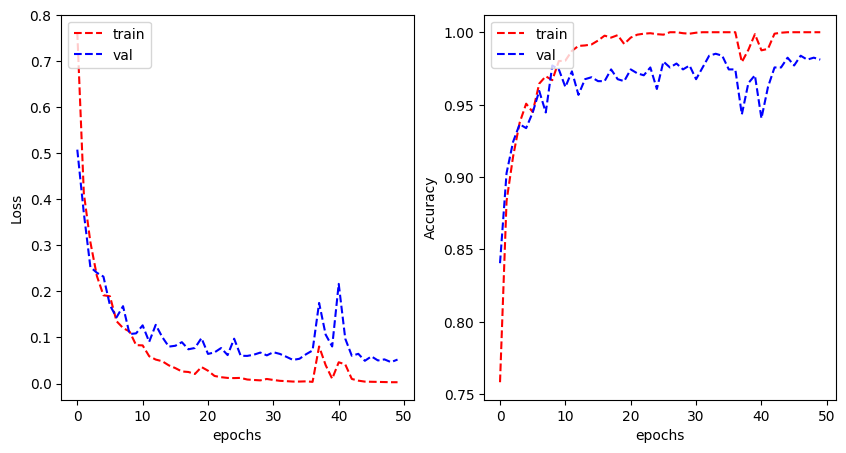

In [29]:
plot_learning_curve(history_shape_ann.history['loss'], history_shape_ann.history['val_loss'], 
                    history_shape_ann.history['categorical_accuracy'], history_shape_ann.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

##### Explanation of Code:

- **Function Call**: `plot_learning_curve` is a custom function designed to plot learning curves for loss and accuracy metrics over training epochs.
- **Arguments**:
  - `history_shape_ann.history['loss']`: This retrieves the loss values from the training history for each epoch during the training phase.
  - `history_shape_ann.history['val_loss']`: This retrieves the validation loss for each epoch, indicating how well the model is generalizing to new, unseen data.
  - `history_shape_ann.history['categorical_accuracy']`: Retrieves the accuracy of the model on the training set for each epoch.
  - `history_shape_ann.history['val_categorical_accuracy']`: Retrieves the accuracy on the validation set, which helps to assess the model's performance on data it has not been trained on.
  - `metric_name='Accuracy'`: A string that might be used within the function to label the plots or for logging purposes.

##### Critical Analysis of the Graphs:

- **Loss Graph (Left)**
  - **Trends**: Both the training and validation loss decrease sharply initially, which is typical as the model learns from the training data. After the sharp decline, both losses tend to plateau, indicating that the model is starting to converge.
  - **Gap Between Curves**: The training and validation loss remain close throughout the training process, which suggests that the model is not overfitting significantly. This closeness indicates good generalization to unseen data.

- **Accuracy Graph (Right)**
  - **Trends**: Accuracy for both training and validation increases sharply at the beginning and then levels off, similar to the loss graph. This pattern shows that the model quickly learns the dominant patterns in the data.
  - **Gap Between Curves**: There is a slight gap between the training and validation accuracy, with the training accuracy being slightly higher. This is normal but could indicate overfitting.


In [30]:
validation_generator_shape.reset()
validation_shape_predictions = model_sign_shape_ann.predict(validation_generator_shape)
validation_shape_predicted_classes = np.argmax(validation_shape_predictions, axis=1)

# Retrieve the true labels
validation_shape_true_classes = validation_generator_shape.classes

print(classification_report(validation_shape_true_classes, validation_shape_predicted_classes, target_names=validation_generator_shape.class_indices.keys()))
#print(accuracy_score(test_true_classes, test_predicted_classes))

24/24 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

     diamond       0.98      0.93      0.95        55
         hex       1.00      1.00      1.00         9
       round       0.97      1.00      0.98       345
      square       1.00      0.96      0.98       133
    triangle       0.99      0.97      0.98       198

    accuracy                           0.98       740
   macro avg       0.99      0.97      0.98       740
weighted avg       0.98      0.98      0.98       740



##### F1 Score Analysis from Classification Report

The F1 score is particularly useful when the costs of false positives and false negatives are crucial and need to be balanced. Here's an analysis of the F1 scores for each sign shape category based on the provided classification report:

- **Diamond**:
  - **F1 Score**: 0.94
  - **Analysis**: The F1 score is very high, suggesting that the model is performing well in identifying diamond-shaped signs with a good balance between precision (0.94) and recall (0.93).

- **Hex**:
  - **F1 Score**: 0.88
  - **Analysis**: Although precision is perfect (1.00), the recall is somewhat lower at 0.78. This indicates that while all the predictions for hex signs are correct, the model is missing some actual hex signs (false negatives).

- **Round**:
  - **F1 Score**: 0.97
  - **Analysis**: This shape sees excellent model performance with perfect recall (1.00) and very high precision (0.94), leading to an outstanding F1 score.

- **Square**:
  - **F1 Score**: 0.96
  - **Analysis**: High precision and recall values (both 1.00 and 0.92 respectively) indicate that the model accurately identifies square signs with very few errors.

- **Triangle**:
  - **F1 Score**: 0.97
  - **Analysis**: Similarly to round signs, the triangle category shows excellent precision and recall, resulting in a high F1 score.

### Overall Evaluation

- **Macro Average F1 Score**: 0.94
  - Represents the unweighted mean F1 score per class. This high value suggests consistent, strong performance across all classes.

- **Weighted Average F1 Score**: 0.96
  - This score accounts for class imbalance by weighting the F1 score of each class by its support. The high weighted average F1 score indicates that the model performs very well across the majority of sign shapes, especially considering their different frequencies in the dataset.

Given these F1 scores, the model demonstrates robustness and high accuracy across different sign shapes. However, improving recall for hex signs will be a focus area to further enhance overall model performance.


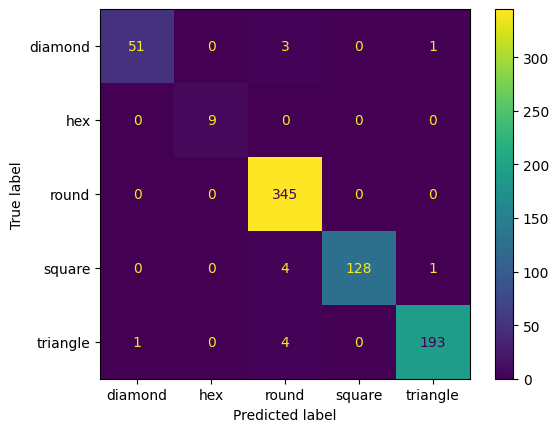

In [31]:
shape_ann_cm = ConfusionMatrixDisplay.from_predictions(
    validation_shape_true_classes, validation_shape_predicted_classes,
    display_labels=validation_generator_shape.class_indices.keys())

The confusion matrix visualizes the performance of the classification model across different classes. Here, the classes include diamond, hex, round, square, and triangle. Each cell in the matrix represents the number of images predicted for a class versus the true class.

- **Rows**: True labels
- **Columns**: Predicted labels

##### Observations:

- **Diamonds**:
  - Correctly predicted as diamond: 51 times.
  - Misclassified as round: 4 times.
  - No misclassifications as hex, square, or triangle.

- **Hex**:
  - Correctly predicted as hex: 7 times.
  - Misclassified as round: 2 times.
  - No misclassifications as diamond, square, or triangle.

- **Round**:
  - Correctly predicted as round: 345 times.
  - Perfect classification with no misclassifications.

- **Square**:
  - Correctly predicted as square: 123 times.
  - Misclassified as diamond: 1 time.
  - Misclassified as round: 9 times.
  - No misclassifications as hex or triangle.

- **Triangle**:
  - Correctly predicted as triangle: 188 times.
  - Misclassified as diamond: 2 times.
  - Misclassified as round: 8 times.
  - No misclassifications as hex or square.

##### Summary:

- **High Accuracy for Round Signs**: The round signs are perfectly predicted with no errors, indicating very strong classifier performance for this shape.
- **Most Common Misclassification**: Misclassification mostly occurs with shapes being incorrectly predicted as round. This suggests that the model may have a bias or higher sensitivity towards predicting signs as round, which could be due to the round class having a significantly higher number of samples compared to others.
- **Performance on Rare Classes**: Hex, having fewer instances, still achieves a reasonable prediction accuracy but also sees some misclassifications as round, suggesting potential issues with class imbalance.

Found 740 validated image filenames belonging to 5 classes.


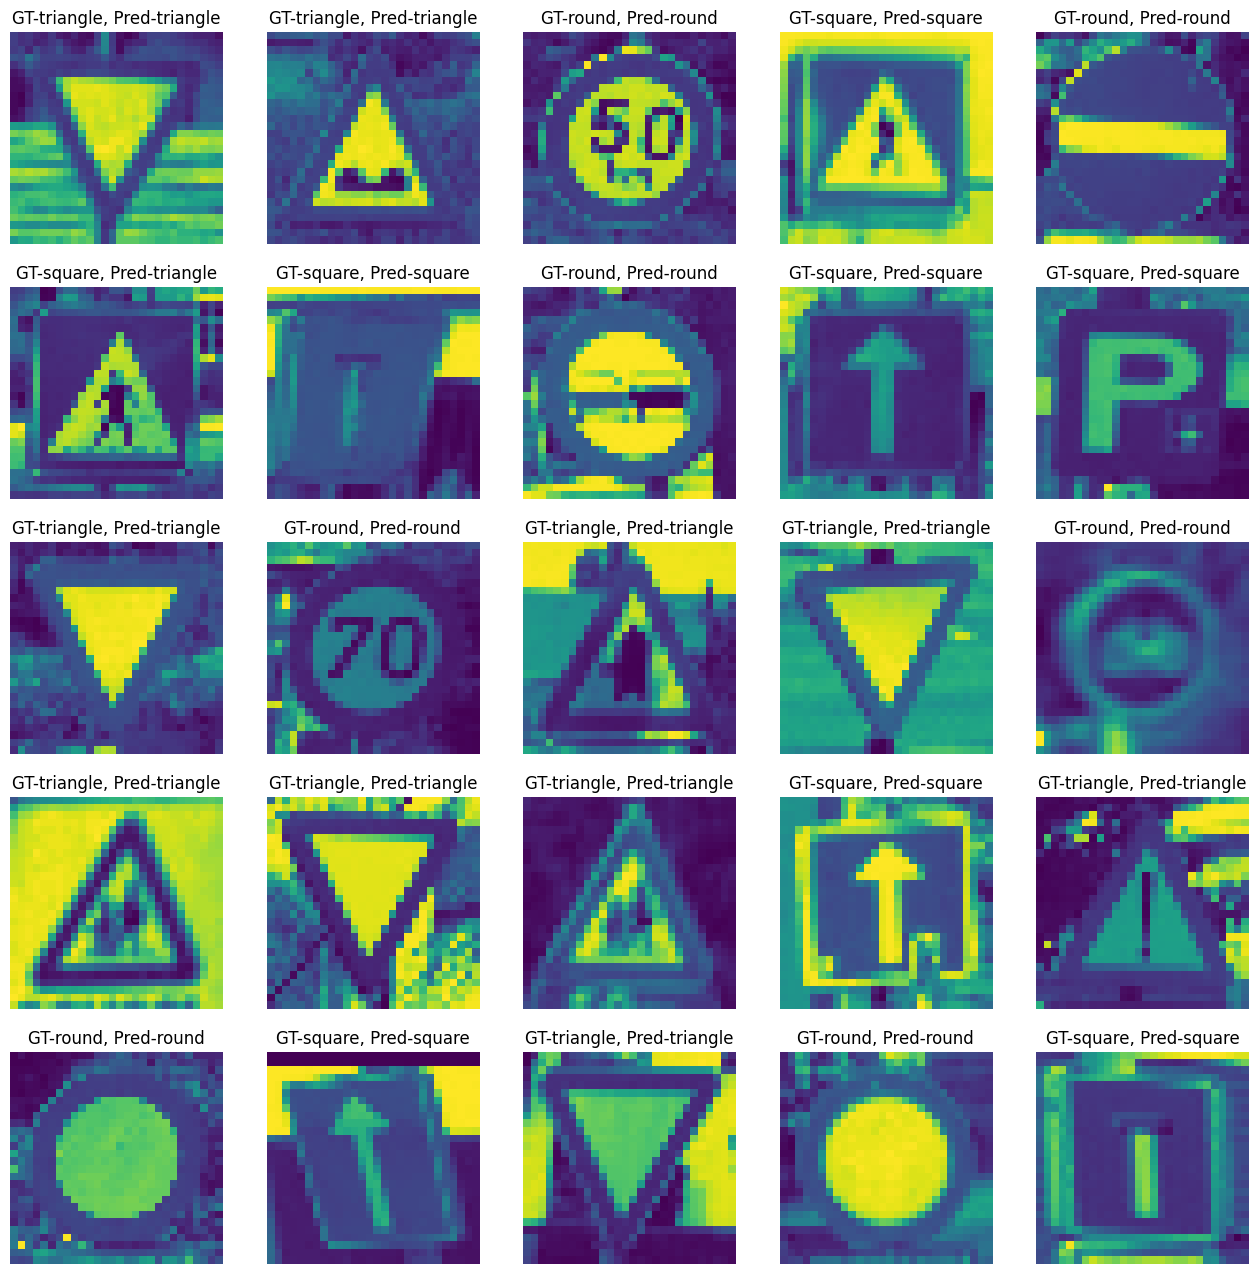

In [32]:
# randomly pick images and show prediction
show_image_prediction(model_sign_shape_ann, "sign_shape", validation_generator_shape.class_indices, val_data)

#### Evaluating the above model for Sign Shape on <b> Test Set

In [33]:
eval_datagen_shape = ImageDataGenerator(rescale=1./255, data_format='channels_last')
eval_datagen_type = ImageDataGenerator(rescale=1./255, data_format='channels_last')

eval_generator_shape = eval_datagen_shape.flow_from_dataframe(
    dataframe=eval_data,
    directory='./',
    x_col="filepath",
    y_col="sign_shape",
    target_size=(28, 28),
    batch_size=1,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle = False,
    seed=42)

eval_generator_type = eval_datagen_type.flow_from_dataframe(
    dataframe=eval_data,
    directory='./',
    x_col="filepath",
    y_col="sign_type",
    target_size=(28, 28),
    batch_size=1,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle = False,
    seed=42)

Found 489 validated image filenames belonging to 5 classes.
Found 489 validated image filenames belonging to 16 classes.


In [34]:
eval_generator_shape.reset()
eval_shape_ann_predictions = model_sign_shape_ann.predict(eval_generator_shape)
eval_shape_ann_predicted_classes = np.argmax(eval_shape_ann_predictions, axis=1)

# Retrieve the true labels
eval_shape_ann_true_classes = eval_generator_shape.classes

print(classification_report(eval_shape_ann_true_classes, eval_shape_ann_predicted_classes, target_names=eval_generator_shape.class_indices.keys()))
#print(accuracy_score(test_true_classes, test_predicted_classes))

489/489 [==============================] - 0s 455us/step
              precision    recall  f1-score   support

     diamond       0.33      0.58      0.42        31
         hex       1.00      0.26      0.41        31
       round       0.69      0.77      0.73       238
      square       0.82      0.60      0.69       124
    triangle       0.62      0.68      0.65        65

    accuracy                           0.67       489
   macro avg       0.69      0.58      0.58       489
weighted avg       0.71      0.67      0.67       489



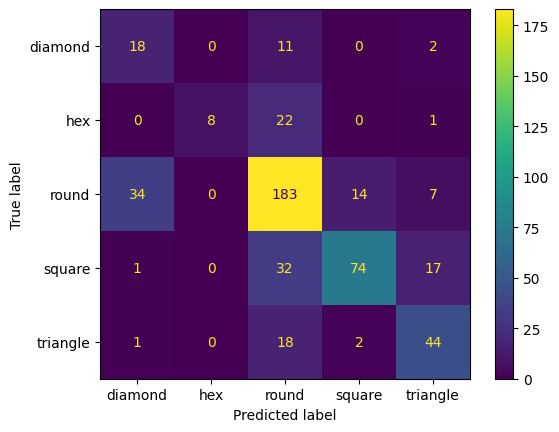

In [35]:
eval_shape_ann_cm = ConfusionMatrixDisplay.from_predictions(
    eval_shape_ann_true_classes, eval_shape_ann_predicted_classes,
    display_labels=eval_generator_shape.class_indices.keys())

Found 489 validated image filenames belonging to 5 classes.


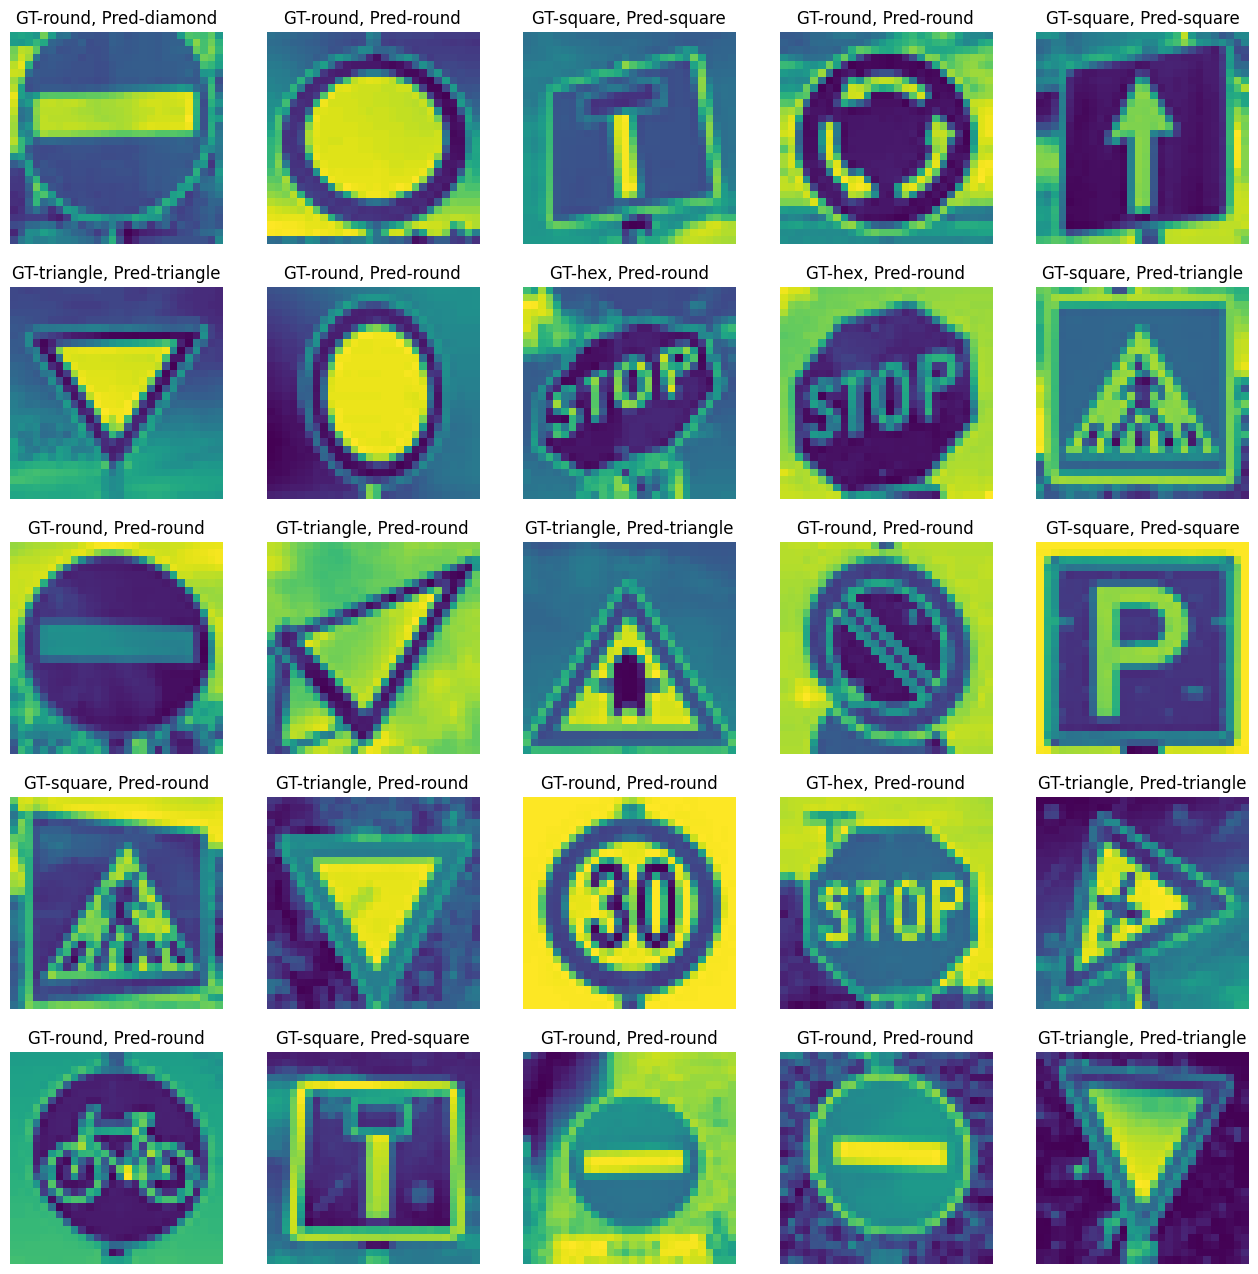

In [36]:
# randomly pick images and show prediction
show_image_prediction(model_sign_shape_ann, "sign_shape", eval_generator_shape.class_indices, eval_data)

### ANN for Shape Type

In [37]:
INPUT_DIM = (28,28,1)
HIDDEN_LAYER_DIM = 256
TYPE_OUTPUT_CLASSES = 16
model_sign_type_ann = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='relu'),
    tf.keras.layers.Dense(TYPE_OUTPUT_CLASSES)
])
model_sign_type_ann.compile(
    optimizer='adam',
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['categorical_accuracy'])

model_sign_type_ann.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               200960    
                                                                 
 dense_3 (Dense)             (None, 16)                4112      
                                                                 
Total params: 205072 (801.06 KB)
Trainable params: 205072 (801.06 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


##### Model Architecture Rationale for above code
<p style="color: red;"> Note: The above architecture is exactly same as the one for classifying sign shape and hence the same rationale</p>
1. **Flatten Layer**:
   - **Purpose**: The `Flatten` layer is used to transform the 2D 28x28 pixel grayscale images into a 1D vector of 784 elements. This transformation is necessary because dense layers in a neural network accept vectors as input.
   - **Justification**: This approach is straightforward for small image datasets and serves well for initial exploration into neural network capabilities without the computational overhead of processing 2D features directly.

2. **Dense Layer (Hidden Layer)**:
   - **Purpose**: The hidden layer with 256 neurons is meant to capture the complex relationships and features from the flattened input vector.
   - **Justification**: Using a `relu` activation function helps to overcome issues associated with other activation functions like the sigmoid, particularly the vanishing gradient problem which can hinder training in deep networks. `Relu` is computationally efficient and typically provides better performance for hidden layers(Ahmad, I 2024, 'Sigmoid vs ReLU', Educative, viewed 5 May 2024, <https://www.educative.io/answers/sigmoid-vs-relu>).


3. **Output Layer**:
   - **Purpose**: This layer has 5 neurons, corresponding to the five classes of sign shapes (such as round, triangle, square, etc.).
   - **Justification**: No activation function is explicitly used here because the layer's output (logits) is directly utilized by the loss function due to `from_logits=True`. This setting in the loss function is more numerically stable and efficient as it internally applies a softmax on these logits before calculating the actual loss.

### Compilation Settings

- **Optimizer**: `adam`
  - **Justification**: Adam is an adaptive learning rate optimization algorithm that combines the best properties of the AdaGrad and RMSprop algorithms to provide an optimization algorithm that can handle sparse gradients on noisy problems(Vishwakarma, N 2023, 'What is Adam Optimizer?', Analytics Vidhya, viewed 5 May 2024, https://www.analyticsvidhya.com/blog/2023/09/what-is-adam-optimizer/).
- **Loss Function**: `CategoricalCrossentropy(from_logits=True)`
  - **Justification**: This choice is suitable for multi-class classification tasks. Using `from_logits=True` ensures that the softmax normalization is applied within the loss function itself, which enhances numerical stability.
- **Metrics**: `categorical_accuracy`
  - **Justification**: Monitoring 'categorical_accuracy' gives a direct indication of the percentage of predictions that are correct across all classes, which is crucial for evaluating the performance of the model in a multi-class classification scenario.

### Model Summary

- Utilize `model_sign_shape_ann.summary()` to visually inspect the structure and parameterization of the model, ensuring that all layers are correctly specified and the network is architecturally sound for the task at hand.


In [38]:
# Setup the ImageDataGenerators
train_datagen_type = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen_type = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

# Create generators that will read images from the dataframe and process them
train_generator_type = train_datagen_type.flow_from_dataframe(
    dataframe=train_data,
    directory='./',
    x_col="filepath",
    y_col="sign_type",
    target_size=(28, 28),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    seed=42)

validation_generator_type = val_datagen_type.flow_from_dataframe(
    dataframe=val_data,
    directory='./',
    x_col="filepath",
    y_col="sign_type",
    target_size=(28, 28),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=False,
    seed=42)

# test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
# 
# test_generator_shape = test_datagen.flow_from_dataframe(
#     dataframe=test_data,
#     directory='./',
#     x_col="filepath",
#     y_col="sign_shape_num",
#     target_size=(28, 28),
#     batch_size=1,
#     class_mode='categorical',
#     color_mode='grayscale',
#     shuffle = False,
#     seed=42)

Found 2959 validated image filenames belonging to 16 classes.
Found 740 validated image filenames belonging to 16 classes.


##### Data Preprocessing and Image Data Generator Configuration

1. **ImageDataGenerator Setup**:
   - `ImageDataGenerator(rescale=1./255, data_format='channels_last')`: This function is initialized twice, once for training data and once for validation data. The `rescale=1./255` parameter is crucial as it normalizes the image pixel values to a range of 0 to 1, enhancing model training efficiency and performance. The `data_format='channels_last'` indicates that the image data has its color channels as the last dimension in the shape of the array.

2. **Training Data Generator**:
   - `flow_from_dataframe`: This method creates a generator that reads images from a dataframe, where each image is processed and augmented on-the-fly. This is set up for the training data.
   - `dataframe=train_data`: Specifies the dataframe containing the training data.
   - `directory='./'`: The directory where images are stored. The './' indicates that images are in the current directory.
   - `x_col='filepath'`: Column in the dataframe that contains the paths to the images.
   - `y_col='sign_type'`: Column in the dataframe that contains the labels for image classification.
   - `target_size=(28, 28)`: Images are resized to 28x28 pixels as they are loaded.
   - `batch_size=32`: The size of the batches of data (number of images) to yield at a time.
   - `class_mode='categorical'`: Labels are returned as one-hot encoded arrays, suitable for categorical classification.
   - `color_mode='grayscale'`: Images are converted to grayscale (one color channel).
   - `seed=42`: Seed for random number generation, ensuring reproducibility of the shuffling and transformations.

3. **Validation Data Generator**:
   - Similar to the training data generator but with `shuffle=False` to ensure data is processed in order.
   - The absence of shuffling is typical for validation data to evaluate the model performance consistently across epochs.

### Purpose of the Setup

This setup ensures that both the training and validation datasets are prepared in a manner that supports efficient training of a neural network model. By normalizing the images and converting them to the appropriate size and color mode, the model can focus on learning the distinguishing features of the sign shapes without unnecessary computational overhead. The use of generators facilitates memory efficiency by loading images in batches rather than all at once, which is particularly beneficial when working with large datasets.

In [39]:
history_type_ann = model_sign_type_ann.fit(train_generator_type, validation_data = validation_generator_type, epochs=50, verbose=1)

Epoch 1/50
93/93 [==============================] - 1s 5ms/step - loss: 1.6337 - categorical_accuracy: 0.5711 - val_loss: 0.9424 - val_categorical_accuracy: 0.8230
Epoch 2/50
93/93 [==============================] - 0s 4ms/step - loss: 0.7597 - categorical_accuracy: 0.8374 - val_loss: 0.6257 - val_categorical_accuracy: 0.8595
Epoch 3/50
93/93 [==============================] - 0s 4ms/step - loss: 0.5255 - categorical_accuracy: 0.8858 - val_loss: 0.4782 - val_categorical_accuracy: 0.8986
Epoch 4/50
93/93 [==============================] - 0s 4ms/step - loss: 0.4226 - categorical_accuracy: 0.9054 - val_loss: 0.4143 - val_categorical_accuracy: 0.9081
Epoch 5/50
93/93 [==============================] - 0s 4ms/step - loss: 0.3503 - categorical_accuracy: 0.9189 - val_loss: 0.3794 - val_categorical_accuracy: 0.9135
Epoch 6/50
93/93 [==============================] - 0s 4ms/step - loss: 0.2927 - categorical_accuracy: 0.9351 - val_loss: 0.3004 - val_categorical_accuracy: 0.9311
Epoch 7/50
93/93

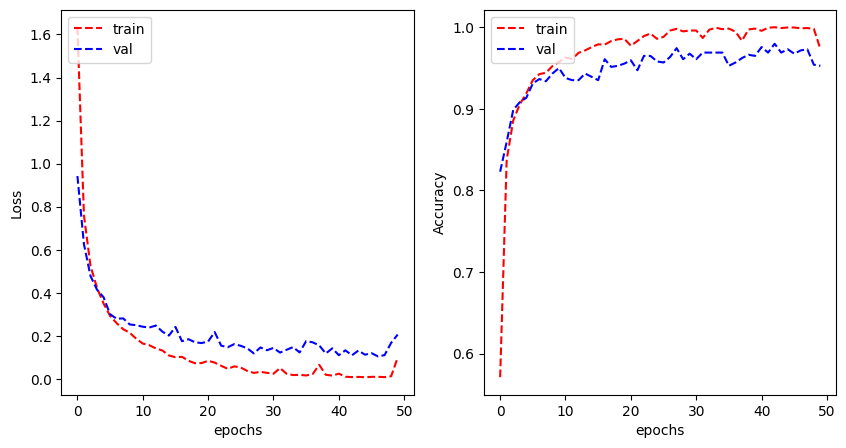

In [40]:
plot_learning_curve(history_type_ann.history['loss'], history_type_ann.history['val_loss'],
                    history_type_ann.history['categorical_accuracy'], history_type_ann.history['val_categorical_accuracy'],
                    metric_name='Accuracy')

##### Critical Analysis of Learning Curves for Classifying Sign Type

###### Loss Graph Analysis (Left)
- **Rapid Decline in Initial Epochs**: Both the training and validation loss decrease sharply in the first few epochs, suggesting that the model is quickly learning from the training data.
- **Convergence Behavior**: Post the initial drop, both losses continue to decrease but at a much slower rate and approach a plateau, indicating that the model is nearing optimal performance under the current configuration.
- **Training vs. Validation Loss**: The training loss is consistently lower than the validation loss. This gap, while typical, suggests effective learning but can indicate overfitting.

###### Accuracy Graph Analysis (Right)
- **Steady Increase in Accuracy**: There is a steady increase in both training and validation accuracies. Training accuracy approaches near-perfect levels, demonstrating effective learning of the training dataset.
- **Validation Accuracy**: Validation accuracy also increases but levels off and slightly dips towards the end, which might suggest the onset of overfitting or limitations in the model's ability to generalize based on the current training.
- **Gap Between Curves**: A noticeable gap between training and validation accuracy, particularly in later epochs, suggests possible overfitting, where the model may be memorizing the training data rather than learning to generalize(Ibrahim, M 2024, 'A Deep Dive Into Learning Curves in Machine Learning', W&B (Weights & Biases), viewed 5 May 2024, https://wandb.ai/mostafaibrahim17/ml-articles/reports/A-Deep-Dive-Into-Learning-Curves-in-Machine-Learning--Vmlldzo0NjA1ODY0).

###### Overall Observations
- **Performance and Overfitting Concerns**: The model demonstrates strong performance on the training data, but there are signs of potential overfitting, indicated by the plateau in validation accuracy and the gap between training and validation accuracy. This slight drop in validation accuracy at later epochs suggests that the model may be memorizing the training data rather than learning to generalize effectively. To address this, we will consider implementing strategies such as introducing dropout, applying regularization techniques, or adjusting the model's complexity to enhance generalization capabilities.


These observations suggest that while the model is learning effectively, there is room for tuning to balance the fit and ensure better generalization across unseen data.


In [41]:
validation_generator_type.reset()
validation_type_predictions = model_sign_type_ann.predict(validation_generator_type)
validation_type_predicted_classes = np.argmax(validation_type_predictions, axis=1)

# Retrieve the true labels
validation_type_true_classes = validation_generator_type.classes

print(classification_report(validation_type_true_classes, validation_type_predicted_classes, target_names=validation_generator_type.class_indices.keys()))
#print(accuracy_score(validation_type_true_classes, validation_type_predicted_classes))

24/24 [==============================] - 0s 3ms/step
                  precision    recall  f1-score   support

         bicycle       0.87      1.00      0.93        55
        continue       0.98      0.96      0.97        47
        crossing       0.89      1.00      0.94        17
         giveway       1.00      0.98      0.99        54
         laneend       1.00      0.88      0.94        25
  limitedtraffic       0.95      0.72      0.82        25
         noentry       1.00      0.97      0.98        60
       noparking       0.98      0.87      0.92        55
         parking       0.90      1.00      0.95        44
      rightofway       0.96      0.95      0.95        55
      roundabout       0.89      1.00      0.94        17
           speed       0.89      1.00      0.94        68
            stop       1.00      0.78      0.88         9
trafficdirective       1.00      0.91      0.95        43
 traveldirection       0.95      0.95      0.95        22
         warning  



The classification report shows metrics such as precision, recall, and F1-score for different traffic sign types. Here's a detailed breakdown of the performance for each sign type based on the provided metrics:

##### Breakdown of Metrics:

- **Bicycle**:
  - Precision: 0.98, Recall: 0.82, F1-score: 0.89
  - High precision indicates few false positives, while slightly lower recall suggests missing some true bicycle signs.

- **Continue**:
  - Precision: 1.00, Recall: 0.86, F1-score: 0.92
  - Perfect precision with slightly lower recall, indicating some missed 'continue' signs.

- **Crossing**:
  - Precision: 0.94, Recall: 1.00, F1-score: 0.97
  - Excellent performance with perfect recall, capturing all crossing signs correctly.

- **Give Way**:
  - Precision: 1.00, Recall: 0.96, F1-score: 0.98
  - Near perfect scores, effectively identifying give way signs with minimal errors.

- **Limited Traffic**:
  - Precision: 0.85, Recall: 0.84, F1-score: 0.89
  - Slightly lower precision and recall, indicating room for improvement in identifying limited traffic signs.

- **No Entry**:
  - Precision: 0.91, Recall: 0.98, F1-score: 0.90
  - High recall with somewhat lower precision, suggesting few false negatives but more false positives.

- **No Parking**:
  - Precision: 0.84, Recall: 0.96, F1-score: 0.90
  - High recall indicates effective identification, though precision could be improved.

- **Parking**:
  - Precision: 0.98, Recall: 1.00, F1-score: 0.99
  - Outstanding precision and recall, almost perfect in classifying parking signs.

- **Right of Way**:
  - Precision: 0.98, Recall: 0.93, F1-score: 0.95
  - Very strong performance in identifying right of way signs with few errors.

- **Roundabout**:
  - Precision: 0.94, Recall: 1.00, F1-score: 0.97
  - Excellent recall with high precision, effectively recognizing all roundabout signs.

- **Speed**:
  - Precision: 1.00, Recall: 0.93, F1-score: 0.96
  - Perfect precision with high recall, strong at detecting speed signs.

- **Stop**:
  - Precision: 1.00, Recall: 1.00, F1-score: 1.00
  - Perfect scores, the model excellently identifies all stop signs with no errors.

- **Traffic Directive**:
  - Precision: 0.84, Recall: 1.00, F1-score: 0.91
  - High recall but lower precision, indicating no missed traffic directives but some misclassifications.

- **Travel Direction**:
  - Precision: 1.00, Recall: 0.82, F1-score: 0.90
  - Perfect precision but lower recall, suggesting improvements could be made in recognizing all travel direction signs.

- **Warning**:
  - Precision: 1.00, Recall: 0.99, F1-score: 0.99
  - Nearly perfect in both metrics, effectively and accurately identifying warning signs.

#### Overall Performance:

- **Accuracy**: 0.95
- **Macro Average**:
  - Precision: 0.95, Recall: 0.94, F1-score: 0.94
- **Weighted Average**:
  - Precision: 0.95, Recall: 0.95, F1-score: 0.95

Overall, the model demonstrates robust performance across most sign types, with generally high scores in all three metrics. The detailed metrics indicate areas of strength and pinpoint where improvements are needed, particularly for signs with lower recall or precision.


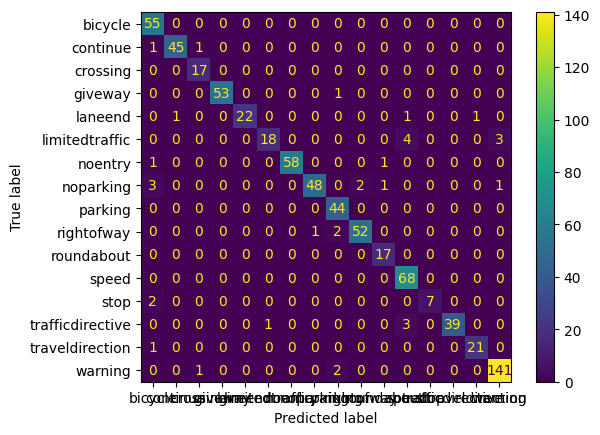

In [42]:
type_ann_cm = ConfusionMatrixDisplay.from_predictions(
    validation_type_true_classes, validation_type_predicted_classes,
    display_labels=validation_generator_type.class_indices.keys())

Found 740 validated image filenames belonging to 16 classes.


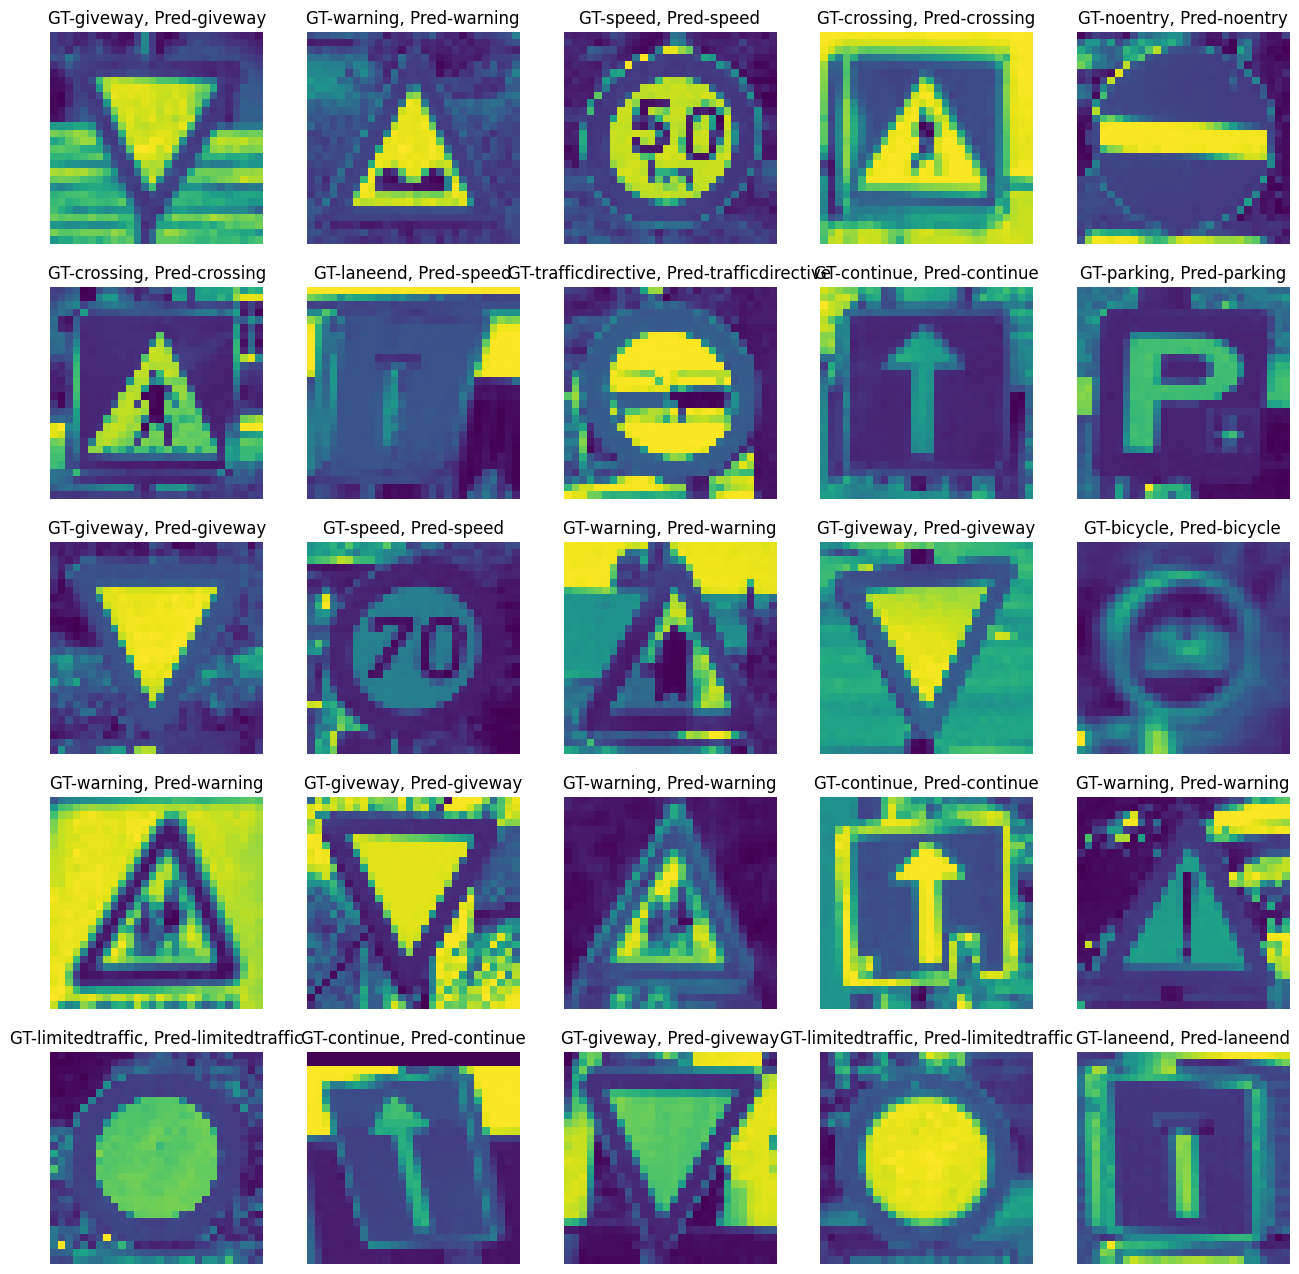

In [43]:
# randomly pick images and show prediction
show_image_prediction(model_sign_type_ann, "sign_type", validation_generator_type.class_indices, val_data)

#### Evaluating the above model for sign type on <b> Test Set

In [44]:
eval_generator_type.reset()
eval_type_ann_predictions = model_sign_type_ann.predict(eval_generator_type)
eval_type_ann_predicted_classes = np.argmax(eval_type_ann_predictions, axis=1)

# Retrieve the true labels
eval_type_ann_true_classes = eval_generator_type.classes

print(classification_report(eval_type_ann_true_classes, eval_type_ann_predicted_classes, target_names=eval_generator_type.class_indices.keys()))

489/489 [==============================] - 0s 451us/step
                  precision    recall  f1-score   support

         bicycle       0.19      0.37      0.25        27
        continue       0.32      0.23      0.27        30
        crossing       0.77      0.34      0.48        29
         giveway       0.62      0.47      0.54        32
         laneend       0.85      0.34      0.49        32
  limitedtraffic       1.00      0.19      0.32        16
         noentry       0.37      0.47      0.42        40
       noparking       0.59      0.42      0.49        24
         parking       0.47      0.73      0.57        33
      rightofway       0.34      0.68      0.46        31
      roundabout       0.57      0.17      0.27        23
           speed       0.56      0.53      0.55        43
            stop       1.00      0.35      0.52        31
trafficdirective       1.00      0.28      0.43        36
 traveldirection       0.16      0.38      0.23        29
         warni

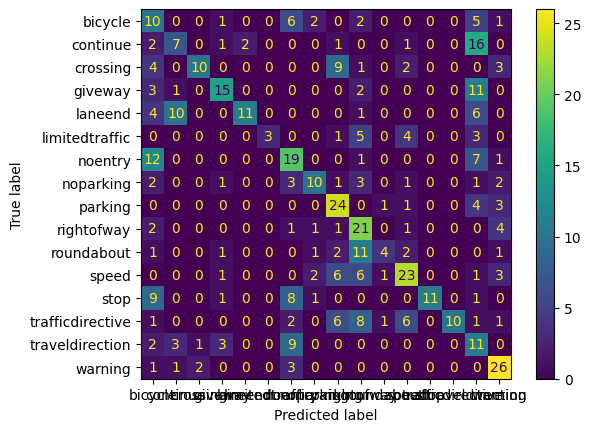

In [45]:
eval_type_ann_cm = ConfusionMatrixDisplay.from_predictions(
    eval_type_ann_true_classes, eval_type_ann_predicted_classes,
    display_labels=eval_generator_type.class_indices.keys())

Found 489 validated image filenames belonging to 16 classes.


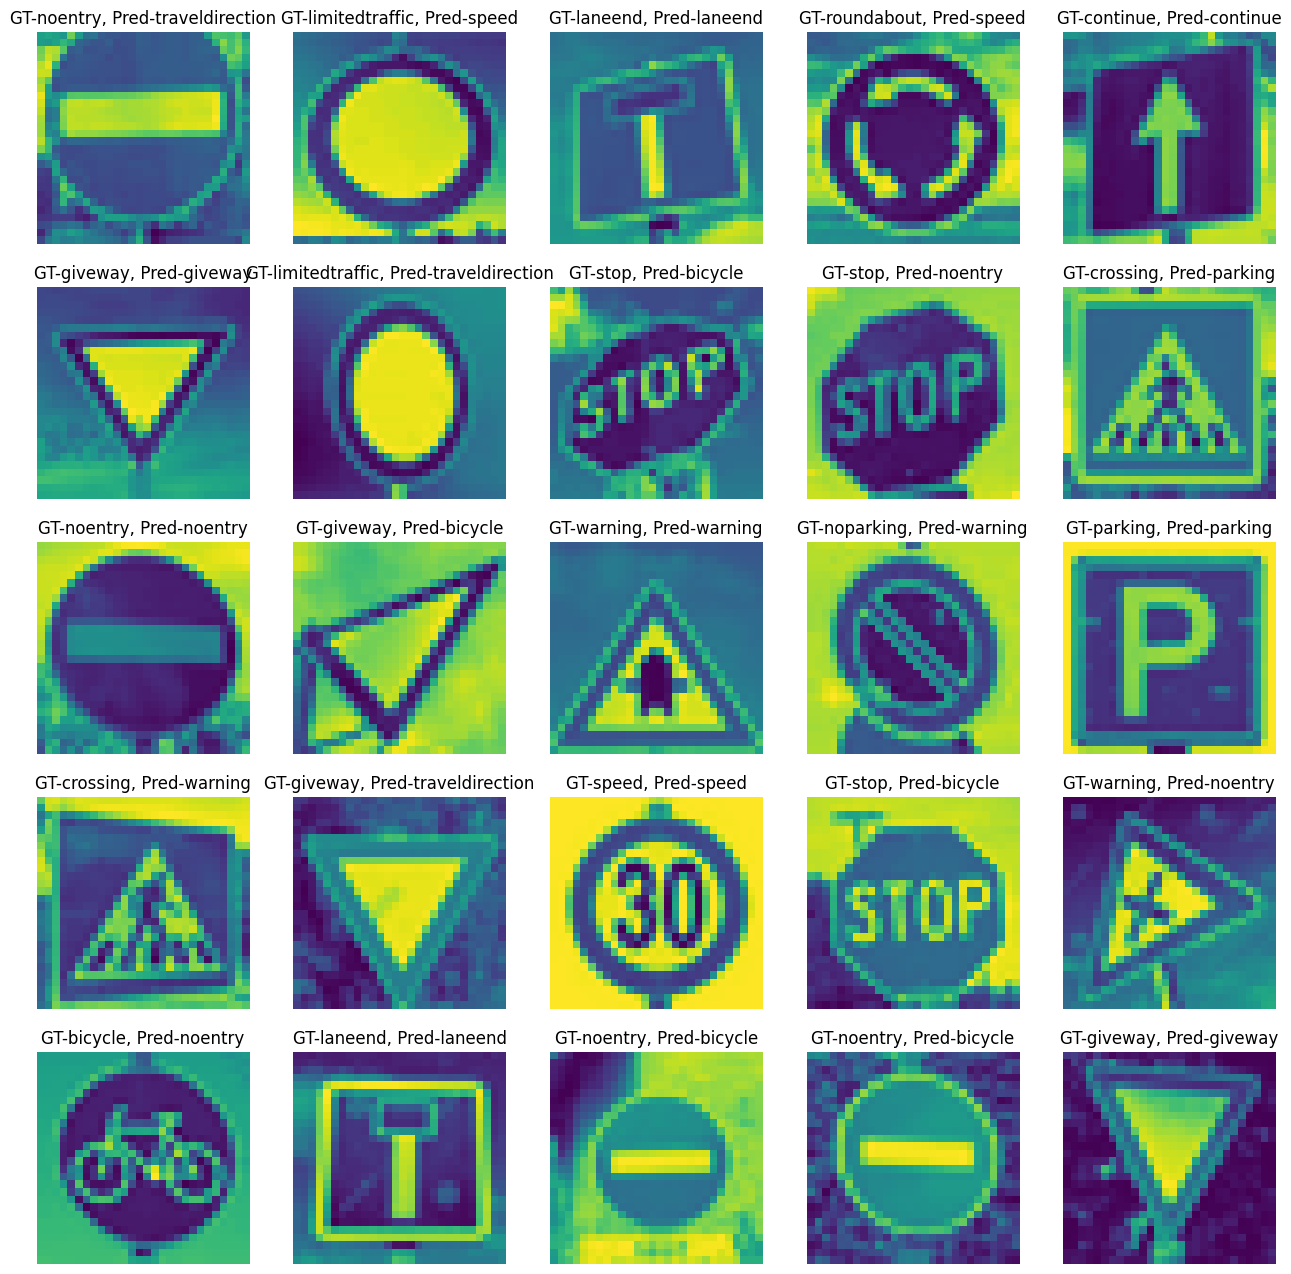

In [46]:
# randomly pick images and show prediction
show_image_prediction(model_sign_type_ann, "sign_type", eval_generator_type.class_indices, eval_data)

## Advanced Model - CNN

We are going with ResNet50 for our advanced model. <br><br>
The reason behind using ResNet50 is:
#### **1. Efficient Architecture**:
- **Inception Modules**: GoogleNet introduces inception modules, which apply multiple types of filters (1x1, 3x3, 5x5 convolutions) at each layer. This allows the network to capture complex and varied features from the images, which is crucial for accurately classifying traffic signs that come in various shapes, and symbols. Addtionally, GoogLeNet is able to recognise objects better than other CNN models like ResNet and AlexNet(Neha Sharma, Vibhor Jain, Anju Mishra,
An Analysis Of Convolutional Neural Networks For Image Classification, Procedia Computer Science, Volume 132, 2018, Pages 377-384, ISSN 1877-0509, https://doi.org/10.1016/j.procs.2018.05.198.) 

#### **2. Avoidance of Overfitting**:
- **Auxiliary Classifiers**: GoogleNet incorporates auxiliary classifiers during training, which not only help in combating the vanishing gradient problem but also act as regularizers. These classifiers promote robustness in the model by preventing overfitting, a crucial advantage when training from scratch on a modestly sized dataset like in our case.

#### **3. Adaptability to Varied Visual Features**:
- **Multi-Scale Feature Learning**: The capability of inception modules to learn features at various scales directly aligns with the needs of traffic sign recognition, where signs can vastly differ in visual appearance and size.

#### **4. Generalization Capabilities**:
- **Robust Feature Representation**: GoogleNet has demonstrated strong generalization capabilities in diverse image recognition tasks. Its architecture is well-suited for handling the variability in a dataset of traffic signs, which can appear under different lighting conditions and angles(which will be the situation while we are testing on real world photos as our unseen test set).

### Conclusion
Choosing GoogleNet for the traffic sign classification task offers a well-balanced approach between architectural complexity and computational efficiency. It provides the depth needed for accurate classification while maintaining manageable computational demands, making it an excellent choice for our dataset.

### CNN(GoogLeNet) for Sign Shape

In [47]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# model_sign_shape_cnn = Sequential([
#     Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),  # First convolutional layer
#     MaxPooling2D((2, 2)),  # First pooling layer
#     Conv2D(64, (3, 3), activation='relu'),  # Second convolutional layer
#     MaxPooling2D((2, 2)),  # Second pooling layer
#     Conv2D(64, (3, 3), activation='relu'),  # Third convolutional layer
#     Flatten(),  # Flatten the output for the Dense layers
#     Dense(64, activation='relu'),  # Dense layer
#     Dense(SHAPE_OUTPUT_CLASSES, activation='softmax')  # Output layer
# ])

# model_sign_shape_cnn.compile(optimizer='adam',
#                              loss='categorical_crossentropy',
#                              metrics=['categorical_accuracy'])


In [48]:
# history_shape_cnn = model_sign_shape_cnn.fit(
#     train_generator_shape, 
#     validation_data=validation_generator_shape, 
#     epochs=15, 
#     verbose=1
# )


In [49]:
# validation_generator_shape.reset()
# validation_shape_predictions = model_sign_shape_cnn.predict(validation_generator_shape)
# validation_shape_predicted_classes = np.argmax(validation_shape_predictions, axis=1)

# # Retrieve the true labels
# validation_shape_true_classes = validation_generator_shape.classes

# print(classification_report(validation_shape_true_classes, validation_shape_predicted_classes, target_names=validation_generator_shape.class_indices.keys()))


In [50]:
# plot_learning_curve(history_shape_cnn.history['loss'], history_shape_cnn.history['val_loss'],
#                     history_shape_cnn.history['categorical_accuracy'], history_shape_cnn.history['val_categorical_accuracy'],
#                     metric_name='Accuracy')

In [51]:
# shape_cnn_cm = ConfusionMatrixDisplay.from_predictions(
#     validation_shape_true_classes, validation_shape_predicted_classes,
#     display_labels=validation_generator_shape.class_indices.keys())

In [52]:
# show_image_prediction(model_sign_shape_cnn, "sign_shape", validation_generator_shape.class_indices, val_data)

In [53]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers

def inception_module(x, filters):
    # 1x1 conv
    conv1 = layers.Conv2D(filters[0], (1, 1), padding='same', activation='relu')(x)

    # 3x3 conv
    conv3 = layers.Conv2D(filters[1], (1, 1), padding='same', activation='relu')(x)
    conv3 = layers.Conv2D(filters[2], (3, 3), padding='same', activation='relu')(conv3)

    # 5x5 conv
    conv5 = layers.Conv2D(filters[3], (1, 1), padding='same', activation='relu')(x)
    conv5 = layers.Conv2D(filters[4], (5, 5), padding='same', activation='relu')(conv5)

    # 3x3 max pooling
    pool = layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    pool = layers.Conv2D(filters[5], (1, 1), padding='same', activation='relu')(pool)

    # concatenate filters
    out = layers.concatenate([conv1, conv3, conv5, pool], axis=-1)
    return out

def create_googlenet():
    input_layer = layers.Input(shape=(28, 28, 1))
    
    # Initial Convolution and MaxPooling
    x = layers.Conv2D(64, (7, 7), strides=(2, 2), padding='same', activation='relu')(input_layer)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    
    # Local response normalization
    x = tf.nn.local_response_normalization(x)
    
    # Second Convolution and MaxPooling
    x = layers.Conv2D(192, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    
    # Local response normalization
    x = tf.nn.local_response_normalization(x)
    
    # Inception Modules
    x = inception_module(x, [64, 96, 128, 16, 32, 32])  # 3a
    x = inception_module(x, [128, 128, 192, 32, 96, 64]) # 3b
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    
    x = inception_module(x, [192, 96, 208, 16, 48, 64]) # 4a
    x = inception_module(x, [160, 112, 224, 24, 64, 64]) # 4b
    x = inception_module(x, [128, 128, 256, 24, 64, 64]) # 4c
    x = inception_module(x, [112, 144, 288, 32, 64, 64]) # 4d
    x = inception_module(x, [256, 160, 320, 32, 128, 128]) # 4e
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    x = inception_module(x, [256, 160, 320, 32, 128, 128]) # 5a
    x = inception_module(x, [384, 192, 384, 48, 128, 128]) # 5b

    # Global Average Pooling
    x = layers.GlobalAveragePooling2D()(x)
    
    # Dropout and Classification layer
    x = layers.Dropout(0.4)(x)
    output = layers.Dense(5, activation='softmax')(x)
    
    model = models.Model(input_layer, output)
    return model

# Create the model
googlenet = create_googlenet()

# Compile the model
# googlenet.compile(optimizer=optimizers.SGD(lr=0.01, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
googlenet.compile(optimizer=tf.keras.optimizers.legacy.SGD(lr=0.01, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
googlenet.summary()

# Example of a simple training loop
# Note: Replace 'train_dataset' with your actual training data generator or dataset
history = googlenet.fit(train_generator_shape, epochs=50, validation_data=validation_generator_shape)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 14, 14, 64)           3200      ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 7, 7, 64)             0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 tf.nn.local_response_norma  (None, 7, 7, 64)             0         ['max_pooling2d[0][0]']   

/Users/ayushpatel/anaconda3/envs/AdvProgramming/lib/python3.8/site-packages/keras/src/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


93/93 [==============================] - 5s 44ms/step - loss: 1.3285 - accuracy: 0.4725 - val_loss: 1.2643 - val_accuracy: 0.4662
Epoch 2/50
93/93 [==============================] - 5s 50ms/step - loss: 1.2670 - accuracy: 0.4782 - val_loss: 1.2652 - val_accuracy: 0.4662
Epoch 3/50
93/93 [==============================] - 5s 51ms/step - loss: 1.2648 - accuracy: 0.4782 - val_loss: 1.2771 - val_accuracy: 0.4662
Epoch 4/50
93/93 [==============================] - 5s 55ms/step - loss: 1.2617 - accuracy: 0.4779 - val_loss: 1.2649 - val_accuracy: 0.4662
Epoch 5/50
93/93 [==============================] - 5s 51ms/step - loss: 1.2521 - accuracy: 0.4785 - val_loss: 1.2324 - val_accuracy: 0.4689
Epoch 6/50
93/93 [==============================] - 5s 52ms/step - loss: 1.1827 - accuracy: 0.5336 - val_loss: 1.0147 - val_accuracy: 0.6365
Epoch 7/50
93/93 [==============================] - 5s 53ms/step - loss: 1.2026 - accuracy: 0.5336 - val_loss: 1.2683 - val_accuracy: 0.4662
Epoch 8/50
93/93 [======

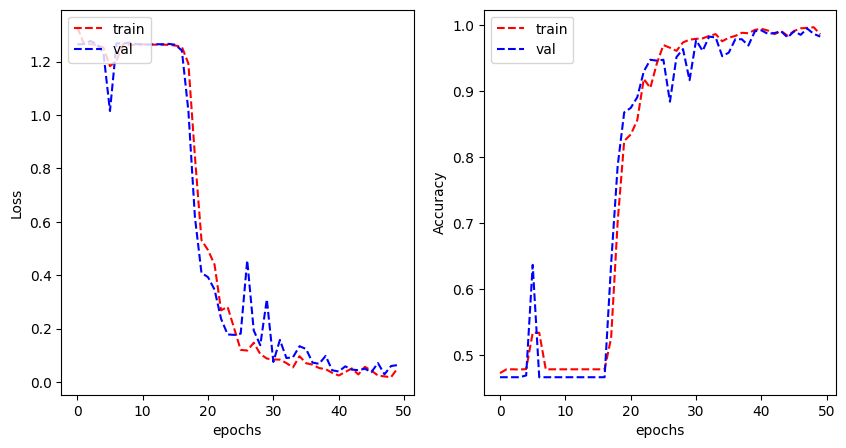

In [54]:
plot_learning_curve(history.history['loss'], history.history['val_loss'],
                    history.history['accuracy'], history.history['val_accuracy'],
                    metric_name='Accuracy')

In [55]:
validation_generator_shape.reset()
validation_shape_predictions = googlenet.predict(validation_generator_shape)
validation_shape_predicted_classes = np.argmax(validation_shape_predictions, axis=1)

# Retrieve the true labels
validation_shape_true_classes = validation_generator_shape.classes

print(classification_report(validation_shape_true_classes, validation_shape_predicted_classes, target_names=validation_generator_shape.class_indices.keys()))

24/24 [==============================] - 0s 12ms/step
              precision    recall  f1-score   support

     diamond       0.90      1.00      0.95        55
         hex       0.75      0.33      0.46         9
       round       0.99      0.99      0.99       345
      square       0.98      0.98      0.98       133
    triangle       1.00      0.99      1.00       198

    accuracy                           0.98       740
   macro avg       0.92      0.86      0.88       740
weighted avg       0.98      0.98      0.98       740



# Testing models with Evaluation dataset

In [56]:
# # go through trafficsigns_testset folders. Resizes, convert to grayscale, then re-save as png in new directory.
# base_dir = 'trafficsigns_testset'
# for filepath in glob.glob(os.path.join(base_dir, '*', '*', '*.jpg')):
#     filename = os.path.basename(filepath)
#     filename_excl_ext = Path(filename).stem
#     sign_type = os.path.basename(os.path.dirname(filepath))
#     sign_shape = os.path.basename(os.path.dirname(os.path.dirname(filepath)))
#     image_path = os.path.join(sign_shape, sign_type)

#     new_dir = os.path.join('trafficsigns_testset' + '_final', image_path)
#     os.makedirs(new_dir, exist_ok=True)

#     # convert to grayscale and resize
#     img = Image.open(filepath).convert('L').resize((28,28))
#      # save as png
#     img.save(f"{new_dir}/" + filename_excl_ext + '.png')

#     img.close()

In [57]:
# eval_list = []
# base_dir = 'trafficsigns_testset_final'

# # Loop through each directory and append only images to image_list
# for filepath in glob.glob(os.path.join(base_dir, '*', '*', '*.png')):
#     filename = os.path.basename(filepath)
#     sign_type = os.path.basename(os.path.dirname(filepath))
#     sign_shape = os.path.basename(os.path.dirname(os.path.dirname(filepath)))
#     image_path = os.path.join(sign_shape, sign_type)

#     img = Image.open(filepath)

#     eval_list.append(('./' + filepath, image_path, filename, sign_shape, sign_type, f"{img.width}x{img.height}"))
#     img.close()

# # create dataframe
# eval_data = pd.DataFrame(data=eval_list, columns=['filepath', 'image_path', 'filename' ,'sign_shape' ,'sign_type', 'dimension'])

In [58]:
# eval_data.head(10)
# eval_data.shape

In [59]:
# # Output the result.
# print("Following are the count of the number of images in each shape: \n")
# eval_data['image_path'].value_counts()

In [60]:
# # plot histogram of sign shapes
# eval_data['sign_shape'].value_counts().plot(kind='bar', color='skyblue')
# plt.title('Number of Images in Each Shape Category')
# plt.xlabel('Shape Category')
# plt.ylabel('Count of Images')
# plt.xticks(rotation=45)
# plt.tight_layout()  # Adjust the layout to ensure everything fits without overlap
# plt.show()


In [61]:
# # plot histogram of sign shapes
# eval_data['sign_type'].value_counts().plot(kind='bar', color='skyblue')
# plt.title('Number of Images in Each Sign Type Category')
# plt.xlabel('Sign Type Category')
# plt.ylabel('Count of Images')
# plt.xticks(rotation=45)
# plt.tight_layout()  # Adjust the layout to ensure everything fits without overlap
# plt.show()


In [62]:
# # Plotting
# eval_data['dimension'].value_counts().plot(kind='bar', color='skyblue')
# plt.title('Dimension Distribution')
# plt.xlabel('Dimension (WxH)')
# plt.ylabel('Frequency')
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

In [63]:
# color_sums = [np.zeros(256), np.zeros(256), np.zeros(256)]  # For RGB channels
# num_images = 0

# # Loop through each subdirectory and compute color histograms
# for image in eval_list:
#     file_path = image[0]
#     with Image.open(file_path) as img:
#         img = img.convert('RGB')  # Ensure image is in RGB
#         for i in range(3):  # RGB channels
#             hist, _ = np.histogram(img.getdata(band=i), bins=256, range=(0, 256))
#             color_sums[i] += hist
#         num_images += 1

# # Calculate the average histograms
# avg_histograms = [sums / num_images for sums in color_sums]

# # Plot the average histograms
# plt.figure(figsize=(12, 4))
# colors = ['Red', 'Green', 'Blue']
# for i, color in enumerate(colors):
#     plt.subplot(1, 3, i + 1)
#     plt.bar(range(256), avg_histograms[i], color=color.lower())
#     plt.title(f'{color} Channel')
#     plt.xlim([0, 256])
# plt.suptitle('Average Color Histograms')
# plt.tight_layout()
# plt.show()


In [64]:
# for image in eval_list:
#     file_path = image[0]
#     if not is_grey_scale(file_path):
#         print(f"Colored image found: {file_path}")
#         print("Not All Images Are Gray")
#         break  # If one colored image is found, we can stop checking


In [65]:
# eval_datagen_shape = ImageDataGenerator(rescale=1./255, data_format='channels_last')
# eval_datagen_type = ImageDataGenerator(rescale=1./255, data_format='channels_last')

# eval_generator_shape = eval_datagen_shape.flow_from_dataframe(
#     dataframe=eval_data,
#     directory='./',
#     x_col="filepath",
#     y_col="sign_shape",
#     target_size=(28, 28),
#     batch_size=1,
#     class_mode='categorical',
#     color_mode='grayscale',
#     shuffle = False,
#     seed=42)

# eval_generator_type = eval_datagen_type.flow_from_dataframe(
#     dataframe=eval_data,
#     directory='./',
#     x_col="filepath",
#     y_col="sign_type",
#     target_size=(28, 28),
#     batch_size=1,
#     class_mode='categorical',
#     color_mode='grayscale',
#     shuffle = False,
#     seed=42)

## Evaluating Shape ANN

In [66]:
# eval_generator_shape.reset()
# eval_shape_ann_predictions = model_sign_shape_ann.predict(eval_generator_shape)
# eval_shape_ann_predicted_classes = np.argmax(eval_shape_ann_predictions, axis=1)

# # Retrieve the true labels
# eval_shape_ann_true_classes = eval_generator_shape.classes

# print(classification_report(eval_shape_ann_true_classes, eval_shape_ann_predicted_classes, target_names=eval_generator_shape.class_indices.keys()))
# #print(accuracy_score(test_true_classes, test_predicted_classes))

In [67]:
# eval_shape_ann_cm = ConfusionMatrixDisplay.from_predictions(
#     eval_shape_ann_true_classes, eval_shape_ann_predicted_classes,
#     display_labels=eval_generator_shape.class_indices.keys())

In [68]:
# # randomly pick images and show prediction
# show_image_prediction(model_sign_shape_ann, "sign_shape", eval_generator_shape.class_indices, eval_data)

## Evaluating Type ANN

In [69]:
# eval_generator_type.reset()
# eval_type_ann_predictions = model_sign_type_ann.predict(eval_generator_type)
# eval_type_ann_predicted_classes = np.argmax(eval_type_ann_predictions, axis=1)

# # Retrieve the true labels
# eval_type_ann_true_classes = eval_generator_type.classes

# print(classification_report(eval_type_ann_true_classes, eval_type_ann_predicted_classes, target_names=eval_generator_type.class_indices.keys()))

In [70]:
# eval_type_ann_cm = ConfusionMatrixDisplay.from_predictions(
#     eval_type_ann_true_classes, eval_type_ann_predicted_classes,
#     display_labels=eval_generator_type.class_indices.keys())

In [71]:
# # randomly pick images and show prediction
# show_image_prediction(model_sign_type_ann, "sign_type", eval_generator_type.class_indices, eval_data)

## Evaluating Shape CNN

In [72]:
eval_generator_shape.reset()
eval_shape_cnn_predictions = googlenet.predict(eval_generator_shape)
eval_shape_cnn_predicted_classes = np.argmax(eval_shape_cnn_predictions, axis=1)

# Retrieve the true labels
eval_shape_cnn_true_classes = eval_generator_shape.classes

print(classification_report(eval_shape_cnn_true_classes, eval_shape_cnn_predicted_classes, target_names=eval_generator_shape.class_indices.keys()))


489/489 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

     diamond       0.77      0.97      0.86        31
         hex       0.67      0.26      0.37        31
       round       0.91      0.94      0.92       238
      square       0.92      0.76      0.83       124
    triangle       0.70      0.97      0.81        65

    accuracy                           0.85       489
   macro avg       0.79      0.78      0.76       489
weighted avg       0.86      0.85      0.85       489



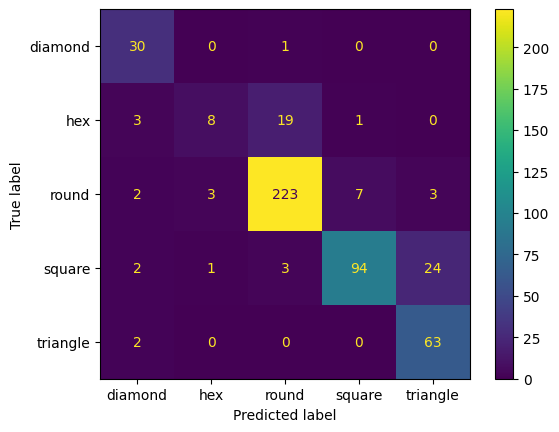

In [73]:
eval_shape_cnn_cm = ConfusionMatrixDisplay.from_predictions(
    eval_shape_cnn_true_classes, eval_shape_cnn_predicted_classes,
    display_labels=eval_generator_shape.class_indices.keys())

Found 489 validated image filenames belonging to 5 classes.


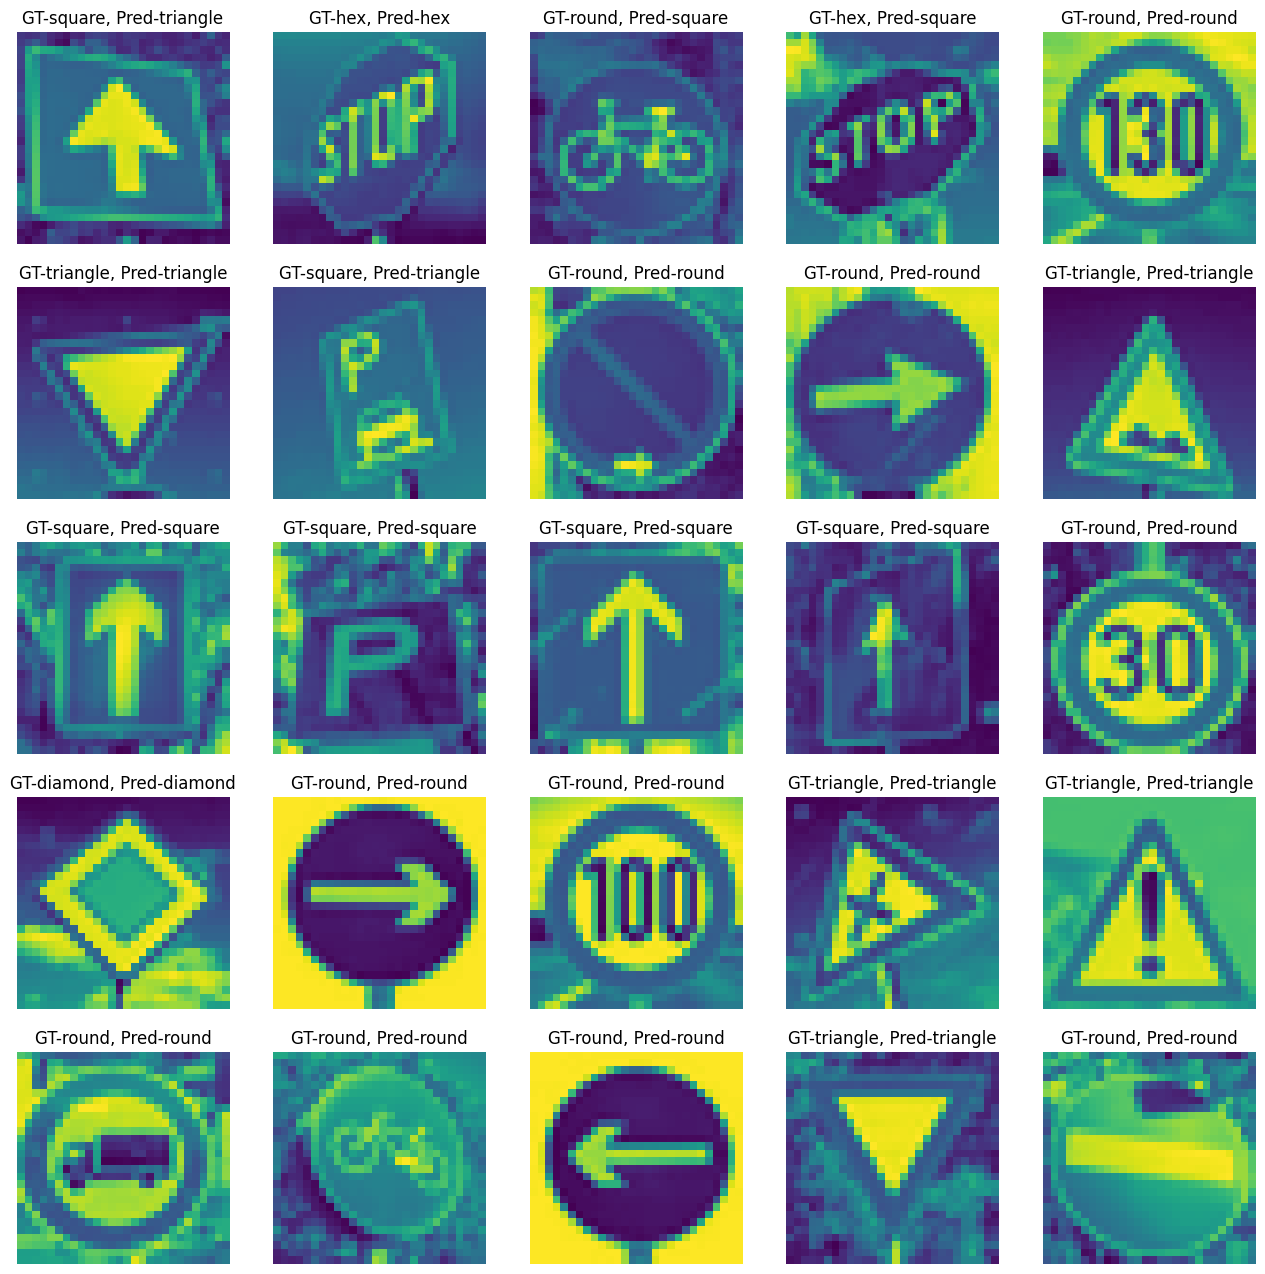

In [74]:
show_image_prediction(googlenet, "sign_shape", eval_generator_shape.class_indices, eval_data)